# CQF Exam 3 Solution | Assigment Module 4 (Choice "_B_") 

**Author**: 
Frank Salvador Ygnacio Rosas 

**Cohort**: January 2022

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# importing base libraries
import sys
import shap
import math
import itertools
import numpy as np
import pandas as pd
import pyfolio as pf
import yfinance as yf
import seaborn as sns
import pandas_ta as tap
import mplfinance as mpf
from datetime import datetime
from termcolor import colored
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# importing sickit learn and related packages
from sklearn import tree
import scikitplot as skplt
from scipy.stats import norm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix, f1_score, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, TimeSeriesSplit

***

## Abstract

The following report implements **Supervised Machine Learning techniques** to predict asset trends. We are going to use Decision Trees and Ensembles methods as the main ML techniques to being evaluated. In that sense, the first part of this study (_Part I_) is focused on the criteria of the asset selection, the process of structure the data, and any other task to overcome to have a useful dataset for the ML implementations. **The second part (_Part II_) contains the main solution of the study based on the exam questions and requirements**; thus, its organization follows the exam structure. Finally, we will add some general refereces for this study.

## I. Part I: Asset selection, data structure and preprocessing

### 1.1. Asset Selection

This study will apply Supervised Machine Learning techniques to perform trend prediction over a dataset of **BlackRock Health Sciences Trust** (NYSE: **BME**). At the close market session of the 10th June, the information available of this company looks like:
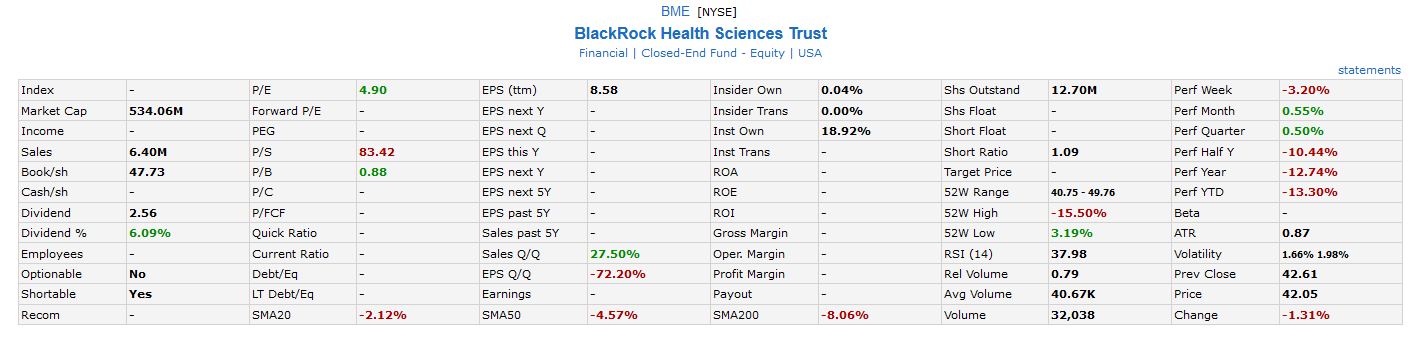
<i><center>Figure 1: BME market information. Source: [Finviz](https://finviz.com/quote.ashx?t=BME) (Accessed June 10, 2022)</center></i>

Even though **BME** is a Closed-End Fund, it works essentially like an ETF; the only difference is that no new shares/cash will be introduced on the fund composition. This is good, since it could be considered as an asset with a low "corporate actions", such as no splits, increments in the shares outstanding, and so on. Moreover, the market cap of **BEM** is about $\$500\text{M}$, making it a small-cap instrument. Also, **BME** has good marks to consider it as “tradable”: an average volume about $40\text{k}$ traded shares per session (which means $\$1.5\text{M}$ more or less), and a monthly volatility of almost $2\%$. Therefore, we decided to select it for our analysis. 

### 1.2. The OHLC Daily Bars

Next, we need to decide which dataype of **BME** we will use to our analysis. Discretionally, we prefer to work over OHLC bars defined on a manageable time-framework; i.e., using daily bars. More precisely, we will use **historical daily OHLC bars of BME from 9th January 2017 to 29th April 2021**. We can get this information directly from the YahooFinance package `yfinance`, such as:

In [2]:
# getting $BME daily OHLC bars from yahoo finance
dataBars = yf.download('BME', 
                      start='2017-01-09', 
                      end='2021-04-29',
                      progress=False,
)

In [3]:
# take a look of the first 5 days of our data
dataBars.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-22,48.560001,48.599998,47.840000,47.970001,45.240597,36700
2021-04-23,48.150002,48.529999,48.150002,48.250000,45.504662,18400
2021-04-26,48.490002,48.730000,48.380001,48.570000,45.806450,22100
2021-04-27,48.750000,49.389999,48.450001,48.849998,46.070526,14100
2021-04-28,48.840000,49.040001,48.439999,48.439999,45.683849,19000


So, based on this information, the visualization of the OHLC bars, say, from **Jan 17th to April 17th, 2019**, looks like:

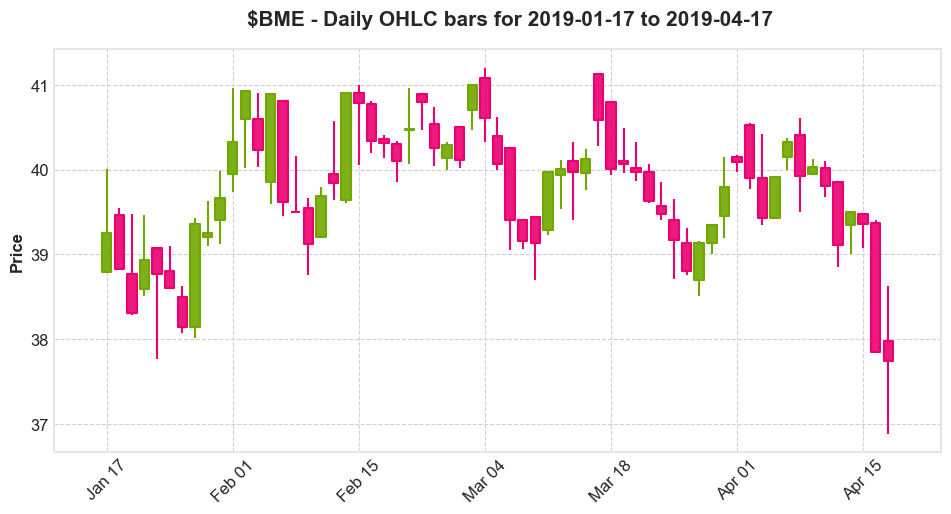

In [4]:
# defining start and end date to plot
startDate, endDate = '2019-01-17', '2019-04-17'

# plot BME OHLC daily bars for specific range of dates
fig, axlist = mpf.plot(
    dataBars.loc[startDate:endDate], 
    type='candle', 
    style='binance',
    update_width_config=dict(candle_linewidth=1.5,candle_width=.75),
    figratio=(15,7),
    returnfig=True,
)
fig = fig.suptitle(
    f"$BME - Daily OHLC bars for {startDate} to {endDate}", 
    y=.95, 
    fontsize=15, 
    weight="semibold",
    x=0.55, 
    style="normal"
)

Finally, with our bar dataset, we are able to compute our features. These will be explained in the next section.

### 1.4. The features

We will compute one feature for each of the 6 feature types given for this study. Particularly, we will use:

- ``O-C`` (output: float value).
- ``Sign of log return`` (output: binary value {$-1, 1$}).
- ``Past returns`` (output: float value).
- ``Momentum`` (output: float value | needs a parameter $k$ to define a window).
- ``Moving Average (SMA)`` (output: float value | needs a paramter $n$ to define amount of useful observations).
- ``Exponential SMA (EMA)`` (output: float value | recursive version).

This features are computed below, and introduced in a ``class`` to simplify its computation.

In [5]:
####################################################################################
# Feature 1: Open - Close | lag of 1 from previous obs. to avoid lookahead bias
def openClose(o, c, lag=1):
    return (o.shift(lag)-c.shift(lag)).values

####################################################################################
# Feature 2: Sign of return | Lag of 1 from previous obs. to avoid lookahead bias
def signLogReturn(c, lag=1):
    return np.sign(np.log(c.shift(1)/c.shift(lag+1))).values

####################################################################################
# Feature 3:  Past Returns | Lag of 1 from previous obs. to avoid lookahead bias
def pastReturns(c, lag=1):
    return dataBars.Close.pct_change().shift(lag).values

####################################################################################
# Feature 4:  Momemtum | Lag of "K":= {1, 10, 15} from previous obs. to avoid lookahead bias
def momemtum(c, lag_list=[1, 10, 15]):
    return [(c.shift(1) - c.shift(lagVal+1)).values for lagVal in lag_list]

####################################################################################
# Feature 5: SMA | Lag of "n":={5, 15, 30} from previous obs. to avoid lookahead bias
def SMA(c, lag_list=[5, 15, 30]):
    return [c.rolling(lagVal).mean().values for lagVal in lag_list]

####################################################################################
# Feature 6:  EMA | Lag of 1 from previous obs. to avoid lookahead bias
def recursiveEMA(c, lag=1):
    """
    General Description:
        This recursive EMA computation use the package:
            >> "pandas_ta" as "tap"
        This compute a simple EMA for a given window from 1+ datapoints.
        Results were tested using the ordinary formulae, and both are the same.
        To read the documentation package, see:
            >> https://twopirllc.github.io/pandas-ta/
    """
    # empty list to save EMAS
    emas = []
    # iteration over range IDX of close prices
    for idxVal in range(0, c.shape[0]):
        # numb. observation definition
        obs = idxVal + 1 
        # ema based on pandas_ta
        emaTemp = tap.ema(c[:obs],obs).values[-1]
        # appending results to emas list
        emas.append(emaTemp) 
    # shifting step: inserting NaN for 1st datapoint to avoid look ahead bias
    emas.insert(0,np.nan)
    # return except last value (because of the shift) to preserve org. lenght
    return np.array(emas[:-1])

In [6]:
class FeaturesComputation(object):
    """
    This is our general Features Computation Class.
    This should be used instead of each single features function.
    """
    # initialization
    def __init__(self, dataset, k=[1, 10, 15], n=[5, 15, 30]):
        self.dataset = dataset
        self.k = k
        self.n = n
    
    # general features computation method
    def compute_features(self, base_lag = 1):
        
        # computation for SMA as dict for all n's
        smaDict = \
        dict(
            zip(
                ["SMA_" + lag for lag in list(map(str, self.n))], 
                SMA(self.dataset.Close, self.n)
            )
        )
        
        # computation for momemtum as dict for all k's
        momemtumDict = \
        dict(
            zip(
                ["momentum_" + lag for lag in list(map(str, self.k))], 
                momemtum(self.dataset.Close, self.k)
            )
        )
                
        # general dict of features
        dictFeatures = {
            "openClose": \
            openClose(self.dataset.Open, self.dataset.Close, base_lag),
            "signLogRet": \
            signLogReturn(self.dataset.Close, base_lag),
            "pastReturns":\
            pastReturns(self.dataset.Close, base_lag),
            "recursiveEMA":\
            recursiveEMA(self.dataset.Close, base_lag),
        }
        
        # returning a compressed general information dictionary
        return { 
            **smaDict, 
            **momemtumDict,            
            **dictFeatures
        }

Notice that some features have certain parameters we should vary to find its best version. These are parameter $k$ (for `Momentum`) and $n$ (for `SMA`). Thus, we propose the following values to test on them:

$$k = \text{{1, 10, 15}} \space\space\text{and}\space\space n = \text{{5, 15, 30}}$$

This leads us to work with 10 features, in which 6 of them are 2 features built on these 3 different values for $k$ and $n$. Important to mention that all of them will be evaluated later to choose the most appropriate for us. 

Hence, after performing the calculations, the features dataset looks like:

In [7]:
# compute general features dataset as dataframe
featuresDf = pd.DataFrame(
    FeaturesComputation(dataBars, k=[1, 10, 15], n=[5, 15, 30]).compute_features()
)
# adding index datetime to features
featuresDf.index = dataBars.index

In [8]:
# check the features for the last 5 observations
featuresDf.tail()

,SMA_5,SMA_15,SMA_30,momentum_1,momentum_10,momentum_15,openClose,signLogRet,pastReturns,recursiveEMA
Date,,,,,,,,,,
2021-04-22,48.384000,47.716000,46.748000,0.649998,2.009998,2.820000,-0.700001,1.0,0.013570,39.211846
2021-04-23,48.274001,47.816000,46.825667,-0.579998,1.290001,1.720001,0.590000,-1.0,-0.011946,39.219963
2021-04-26,48.248000,47.924667,46.914333,0.279999,1.119999,1.500000,-0.099998,1.0,0.005837,39.228324
2021-04-27,48.438000,48.070000,46.989667,0.320000,1.160000,1.630001,-0.079998,1.0,0.006632,39.236966
2021-04-28,48.416000,48.196667,47.074333,0.279999,1.129997,2.180000,-0.099998,1.0,0.005765,39.245850


Finally, in the next section, we will set our labels to the aim of trend prediction. 

### 1.5. The labeling method

There are many labeling techniques we can apply in the "next return" prediction scenario. Some of them are based on tendencies, such as the “Trending Scanning” method (see Lopez de Prado, 2020), or defined by dynamic thresholds of returns, such as the “Triple Barrier” method (see Lopez de Prado, 2018). However, since the aim of this study if focused on the ML implementations, we will define a simple “Naïve Labeling Rule”. This is not an optimal process, and we emphasize why later. However, it is useful as our first approach. In that sense, we will simply **categorize positive returns as 1, and 0 otherwise**; i.e, for a set of returns {$r_t$}$_{t=1, ..., T}$ computed from `Close` prices, we apply:

$$ y_i =   \left\{
\begin{array}{ll}
      1 & r_i> 0 \\
      0 & \text{otherwise}
\end{array} 
\right.
$$

Thus, computing this rule, we can get:

In [9]:
# setting historical laged returns as fwd returns to compute the labels
# this will be useful later in the Question 4 for the backtesting stage
dataBars["fwd_returns"]=dataBars.Close.pct_change().shift(-1)

In [10]:
# returns above 0 will be categorize as 1, and 0 otherwise
dataBars["Label"] = dataBars["fwd_returns"].apply(
    lambda ret: 1 if ret>0 else (0 if ret < 0 else ret)
)
# Detecting % of each type of labels to see if they are well-balanced
print(f":::>>> Counting labels for BME bars dataset (Obs.:{dataBars.shape[0]}):")
print("- Label '0':",round(dataBars.query("Label == 0").shape[0]/dataBars.shape[0],4)*100,"%")
print("- Label '1':",round(dataBars.query("Label == 1").shape[0]/dataBars.shape[0],4)*100,"%")

:::>>> Counting labels for BME bars dataset (Obs.:1083):
- Label '0': 48.75 %
- Label '1': 51.15 %


So far so good, this seems to be well-balanced observations among labels. However, later on, we will provide an special treatment when $r_i \approx 0$ by defining a _rule_ to drop these observations from the training set.

Finally, plotting an interval, say, for the previous range of **Jan 17th to April 17th, 2019**, we can clearly see the labels:

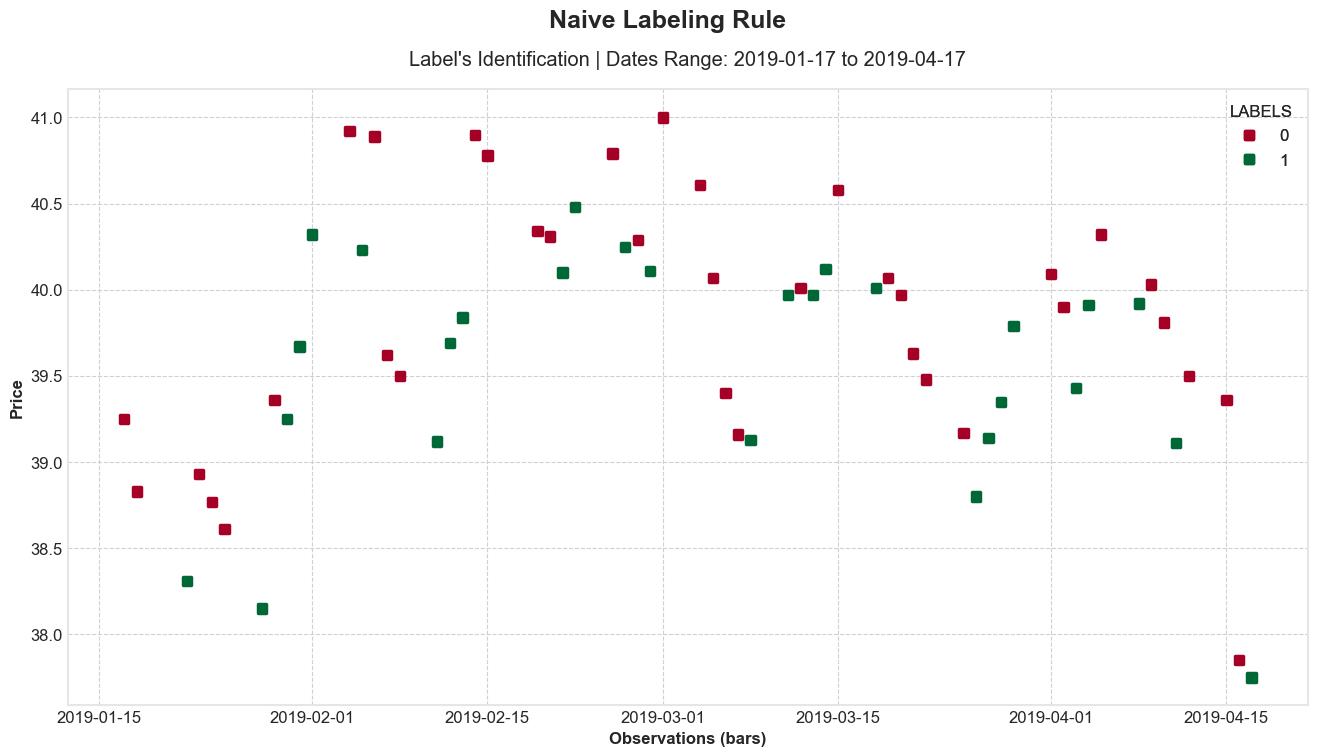

In [11]:
# selecting specific date
df0 = dataBars.loc[startDate:endDate].dropna()

##### >>> Plotting labels for the specified ranges of dates
fig, ax = plt.subplots(figsize=(16,8))
scatter = ax.scatter(
    df0.index, df0.Close.values, 
    c=df0.Label.values, cmap='RdYlGn', 
    alpha=1, linewidths=2.5, marker='s'
)
legend1 = ax.legend(*scatter.legend_elements(), title="LABELS")
ax.add_artist(legend1)
plt.xlabel('Observations (bars)')
plt.ylabel('Price')
plt.suptitle('Naive Labeling Rule',
          fontsize=18, 
          weight="bold")
plt.title(f"Label's Identification | Dates Range: {startDate} to {endDate}", y=1.025)
plt.show()

This is the end of **Part I**. In the next part, we are going to solve the requirements of this study.

## II. Part II: The ML implementations (exam solution)

### 2.1. Question 1: Theory tasks

#### 2.1.1. Loss functions for decision trees

Since we are going to deal with decision trees for classification tasks, we should focus on suitable loss functions for it. Thus, the aim of any decision-tree classifier is to get node/leaves with one dominant class, so its loss function should be defined in terms of the proportions $p$ for a given class $j$ from all the categories $J$ available at ech node/leaf. In that sense, there are $3$ well known loss functions useful in this context:

* Gini Impurity Index:
$$
    G(\text{node}) = \sum_{j=1}^{J}p_j\times(1-p_j)
$$

* Entropy:
$$
    E(\text{node}) = -\sum_{j=1}^{J}p_j\times\log{p_j}
$$

* Misclassification error:
$$
    M(\text{node}) = 1 - \max_{j}(p_j)
$$

Where:
$$
p_j = \frac{\text{observations with class}\space j}{\text{total observations in}\space node},
$$

could be interpreted as the proportion/probability of picking a datapoint of class $j$. 

In this study, we will mostly use _Gini Impurity Index_ as our main loss function.

#### 2.1.2. Which data transformation can prepare the data for linear separation?

In the aim to get linear separation in our decision boundaries, the most common data transformation we can afford is well-known as **Principal Component Analysis (PCA)**. This is, perhaps, the most used technique to achieve a linear separation in a new reduced dimensional dataset. The method first identifies the best hyperplane the fits the data, and then apply a orthogonal projection on it. With this, PCA separates the data points based on the highest observed variation, reducing its dimensionality while preserving the variance. The final outcome is a better representation of our observations that tends to be linear separable, but a cost of lost of dimensionality (i.e., information) and interpretability. 

### 2.2. Question 2: Decision Tree models

#### 2.2.0. Preliminary modifications

First, let's split our general dataset between training and testing. We will use a `test_size = 0.3` because, in the next step, we will deal with the special case $r_i \approx 0$ by dropping some datapoints given a rule. So, this test size ensures we will end up with a well-balanced set of observations for training and testing. 

Thus, applying a general split to our base dataset, we can get::

In [12]:
# first, let's define our general useful features dataset 'X'
X = featuresDf.loc[dataBars.dropna().index].dropna()

# second, let's define our general useful labels dataset 'y'
y = dataBars.iloc[:,-2:].loc[X.index]

# third, apply a traditional splitting process to our data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0, shuffle=False
)

# finally, let's see the shapes of training data
print(":> Training observations:", X_train.shape[0],f"({round(X_train.shape[0]/X.shape[0],3)*100}%)")
# and the % of ocurrencies of each label
print(f":::>>> Label '0' obs.: {round(y_train.query('Label == 0').shape[0] / y_train.shape[0], 5) *100}%")
print(f":::>>> Label '1' obs.: {round(y_train.query('Label == 1').shape[0] / y_train.shape[0], 5) *100}%\n")
# also, let's see the shapes of test data
print(":> Testing observations:", X_test.shape[0],f"({round(y_test.shape[0]/X.shape[0],3)*100}%)")
# and the % of ocurrencies of each label
print(f":::>>> Label '0' obs.: {round(y_test.query('Label == 0').shape[0] / y_test.shape[0], 6) *100}%")
print(f":::>>> Label '1' obs.: {round(y_test.query('Label == 1').shape[0] / y_test.shape[0], 6) *100}%")

:> Training observations: 737 (70.0%)
:::>>> Label '0' obs.: 47.626000000000005%
:::>>> Label '1' obs.: 52.373999999999995%

:> Testing observations: 316 (30.0%)
:::>>> Label '0' obs.: 51.582300000000004%
:::>>> Label '1' obs.: 48.4177%


Now, as we already said, we should take care about the special case when $r_i \approx 0$ in our OHLC bars dataset. Particularly, such returns could be easly considered as _noise_, since there is a high probability they cannot be able to discriminate well between labels, and, thus, affect the learning process. Moreover, if we consider a more "real" scenario, such returns are detrimental due to the existence of transaction costs, slippage, and other trading factors. Therefore, it is almost mandatory to deal with this problem.

So, we will drop every datapoint of the special case only if its associated returns $|r_i| < \gamma$. We are going to define $\gamma$ based on the information we have in the bars dataset using the _downside risk_, well-known as the **semideviation**. This concept could be defined as:

$$
\sigma_{semi} = \sqrt{\frac{1}{n}\sum_{r_i\space<\space\bar{r}}^n(r_i - \bar{r})^2}
$$

Being $n:=$ the total sample observations. 

Thus, using this definition, we can set our $\gamma$ as:

$$
\gamma = \sigma_{semi} \times \frac{1}{10}
$$

Therefore, we will **drop every observation for which its associated absolute return is below the first percentile of the semideviation** for the given sample. This will be done ony on the training set to avoid any bias. Moreover, this procedure prevents the model from learning those observations whose associated returns is so small in such a way that the may be detrimental to the labels classification.

Thus, applying this process, we can get:

In [13]:
# let's compute the gamma value based on the rule defined above 
gammaValue= round(
    y_train.query('fwd_returns<@dataBars.fwd_returns.mean()').fwd_returns.std()/10, 
    5
)

print(":> Considering 𝛾 := ", round(gammaValue*100,4), "%")
# finally, let's drop obs such as its associated returns folows: 𝛾- < r < 𝛾+
y_train_f = y_train.query("~(-@gammaValue<fwd_returns<@gammaValue)")
X_train_f = X_train.loc[y_train_f.index]

# and let's see the new shape of our training dataset
print(":> New training set observations:", X_train_f.shape[0],f"({round(X_train_f.shape[0]/X.shape[0],4)*100}%)")

print(f":::>>> Label '0' obs.: {round(y_train_f.query('Label == 0').shape[0] / y_train_f.shape[0], 6) *100}%")
print(f":::>>> Label '1' obs.: {round(y_train_f.query('Label == 1').shape[0] / y_train_f.shape[0], 6) *100}%")

:> Considering 𝛾 :=  0.089 %
:> New training set observations: 671 (63.72%)
:::>>> Label '0' obs.: 46.4978%
:::>>> Label '1' obs.: 53.5022%


Our new training dataset represents $63.72\%$ of the total observations; i.e, we have $63.72\%$ datapoints for training, and $30\%$ for testing, which more or less **represents $1$ out-of-sample (OOS) observation per $2$ in-sample (IS) datapoints**, a fair ratio.

Finally, with our fixed training dataset, we are able to start our ML implementations.

#### 2.2.1. Vary hyperparameters for Model 1 & Model 2 (POINT 1)

##### 2.2.1.1. The values for the hyperparameters

We know decision trees work over very few assumptions about the data. So, if we feed our decision trees in this unconstrained environment, there is a huge probability of overfitting, mainly because we have not determined any parameter before the learning process. To deal with this, we need to regularize our hyperparameters by defining a "criteria" to control the values given to them during the training process. Thus, the question requires to work over a `Randomized/GridSearch-CV` using:

- `min_samples_split`
- `min_samples_leaf`
- `max_depth`

Thus, to avoid any discretionary bias, we can define the values for these three variables in a statistical way. From the CQF lectures, we know that the "crucial" hyperparameter is `min_samples_leaf`. This hyperparameter controls the minimum number of samples to exist in a leaf. In general, we expect that each leaf-node could categorize very well our labels. So, if the samples needed for this are just a few, the tree will ask for more depth to fit its structure to the training data; if we increase it too much, the tree will not ask for more depth, but none of these leaf-nodes will categorize correctly any label because they will have a lot of samples, being the final label randomly selected (a high "impurity"). Moreover, considering we normally use more samples to split an internal node than the ones to be in a leaf, we can say there is a "_triple trade-off_" between these hyperparameters based on the value used for `min_samples_leaf`.

Hence, we need to start by defining some reference for it. Let's say we expect an error of $5\%$ per leaf during the classification task. So, we may ask to find the number of samples in such a way that, with $95\%$ confidence, we ensure us to get more observations of one category only. This means we need to estimate the proportion of observations that fall into a specific label of interest for this given confidence, that is, its _confidence interval_. More precisely, we need the **Margin Error** (ME), because it represents the amount of observations to consider from the sample proportion to "be sure" we will get anything above the $50/50$ occurrencies to our label of interest. This is exactly what we expect on each leaf: the unbalanced distribution of one label against the other; i.e., that each leaf mostly represents one class.

Thus, this ME can be estimated as:

$$
\text{ME}_{\{l,\space C\%\}} = \sqrt{\hat{P_l} \times \frac{1-\hat{P_l}}{n}}\times Z_{C\%}
$$

Being $\hat{P}$ the proportion of the label of interest $l$, $n$ the sample size, and $Z$ the standard normal test value for an specific confidence level $C\%$. Particularly, we will estimate our min sample size $\omega$ for each leaf by finding:

$$
\omega_{\{l,\space C\%\}}  \approx n \times \text{ME}_{\{l,\space C\%\}} 
$$

Particularly, we will work with a $C\%=95\%$, $Z_{C\%}=1.96$, $n=$ the size of our training sample, and $l=\{1\}$ as our label of interest. 

In [14]:
# find "P" for the label of interest (we've already done this in the previous code cell)
proportion = y_train_f.query('Label == 1').shape[0] / y_train_f.shape[0]
# next, estimate the Margin Error (ME)
ME_95 = np.sqrt(proportion * ((1-proportion)/y_train_f.shape[0])) * 1.96 
# finally, we define our min sample size 𝜔
omega = y_train_f.shape[0]*ME_95
print(f":::>>> Our estimated value for 'min_sample_leaf' is 𝜔 ≈ {math.ceil(omega)} observations")

:::>>> Our estimated value for 'min_sample_leaf' is 𝜔 ≈ 26 observations


Now, having a reference of how many samples we expect to consider an error of $5\%$ per leaf, we could be flexible or strict by defining a range of values that includes this $\omega$. Particularly, we decide to be "strict", since **Question 2** requires later on to postulate and applicate some _prunning_ principles. 

In that sense, we will define an unique value for our main hyperparameter:

- `min_samples_leaf = 26` (regularized hyperparameter)

Based on this _constraint_, we expect the model to work on a depth that is neither too low or too high for our trees. However, we need to validate this assumption. Thus, we will do it by testing:  

- `min_samples_split = [50, 55, 60, ..., 100]`
- `max_depth = [2, 3, 4, ..., 10]`

If the model selects a maximum depth of, say, $9$ or $10$, we will pretty sure something goes wrong—and acceptable range of values should fall in the range between $4\text{-}6$, since we do not expect that any of our models work properly in a small depth as well. In the case of `min_samples_split`, any chosen value could be considered appropiate because we have restricted them, following the "rule of thumb" that an internal node should have, at least, twice as many minimum samples as its leaves ($26 \times 2 = 52\text{, so }50$ as our starting point).

Therefore, in the next section, we will use a `GridSearch-CV` to find the "optimal" value. Moreover, later on, in section 2.2.2., we will come back here to understand that this procedure to _impose_ a criteria for the values of these hyperparamets is well-known as _prunning_ method.

##### 2.2.1.2. The split over a time series and the score-metric to evaluate

It is important to mention that we cannot start our hypertunning process by using directly our training dataset. This is because this data represents a time series, which means that the sequence of events should be preserved. So, we will use the package `TimeSeriesSplit` from scikit-learn, which preserves the order of the datapoints for the aim of the cross-validation process that happens inside the `GridSearch`. Additionally, given that we have $671$ datapoints in our training dataset, we consider appropiate to work over `n_splits=5` for this process.

Finally, we will use the _Area Under the Reciever Operating Characteristic Curve_ (ROC-AUC) for this process. We decide to use it because this metric effectively represents the capability of a model to distinguish between labels by computing the probability curve as a measure of separability. This is important, becase we expect that the `GridSearch` tell us whether the model can distinguish as much as possible the _noise_ from the _signal_, an extremely relevant condition in the conext of the financial markets.

Thus, computing this process over our **Model 1**, we get:

In [15]:
# 1) defining base DecisionTree Classifier for Model 1 (random state = 0)
model1 = DecisionTreeClassifier(min_samples_leaf=26, random_state=0)

# 2) defining the random grid dictionary
grid_dictionary = {
    # min samples to split a internal node
    'min_samples_split': range(50, 105, 5),
    # max. number of levels in a tree (desired the minimum as possible)
    'max_depth': range(2, 11)
}

# 3) defining Grid Search CV object
model1_grid = GridSearchCV(
          estimator = model1, 
          param_grid = grid_dictionary, 
          cv = TimeSeriesSplit(n_splits=5),
          verbose=2,  
          n_jobs = -1,
          scoring="roc_auc"
      )

# 4) running the Grid Search CV using the fixed training data sorted by time
#    this is important since it's necessary for the `TimeSeriesSplit` implementation
model1_grid.fit(X_train_f, y_train_f.Label)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeClassifier(min_samples_leaf=26,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 11),
                         'min_samples_split': range(50, 105, 5)},
             scoring='roc_auc', verbose=2)

:::>>> Model selected during the GridSearch:
       >> Model 1:  DecisionTreeClassifier(max_depth=6, min_samples_leaf=26, min_samples_split=50,
                       random_state=0)
       >> Best score IS (ROC-AUC):  0.54 

:::>>> Model 1 tree structure:


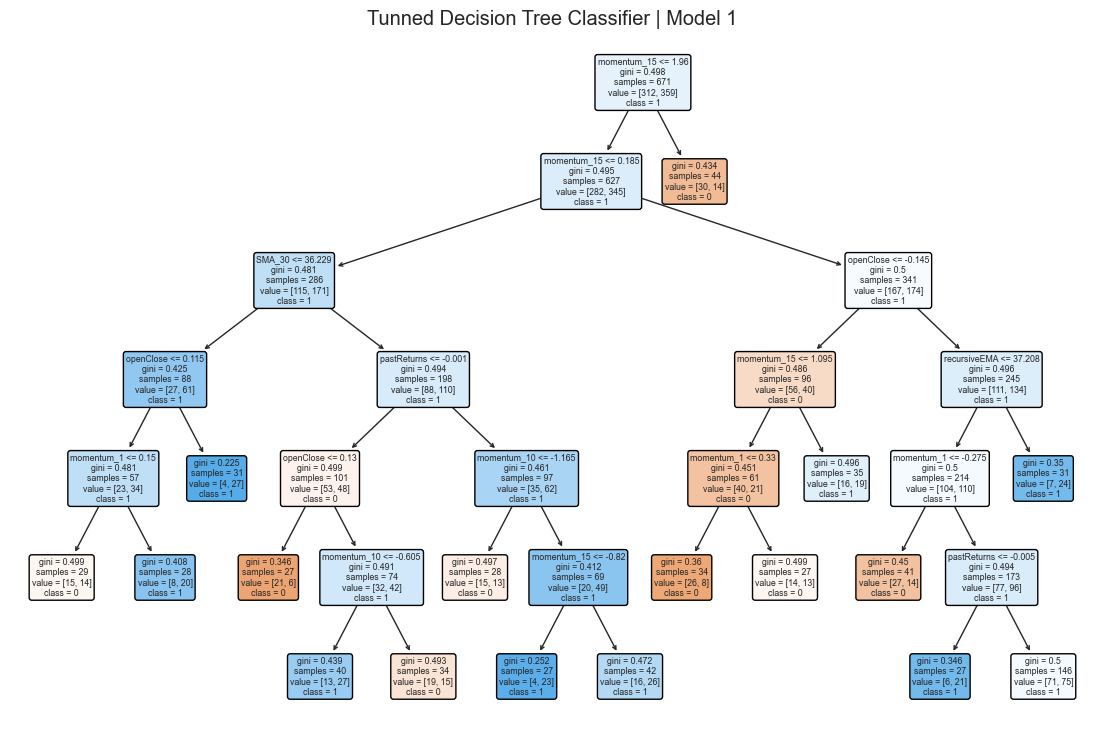

In [16]:
# 5) selecting best Model 1 from the GridSearch, printing its training score and plotting its structure
bestModel1 = model1_grid.best_estimator_
print(":::>>> Model selected during the GridSearch:")
print("       >> Model 1: ",bestModel1)
print("       >> Best score IS (ROC-AUC): ",round(model1_grid.best_score_, 2), "\n")
print(":::>>> Model 1 tree structure:")
# plotting the tree
plt.figure(figsize=(14,9))
tree.plot_tree(
    bestModel1, filled=True, rounded=True, 
    class_names=["0", "1"], feature_names=list(X.columns)
)
plt.title("Tunned Decision Tree Classifier | Model 1")
plt.show()

Now, we can test this **Model 1** using our testing dataset, and computing its results:

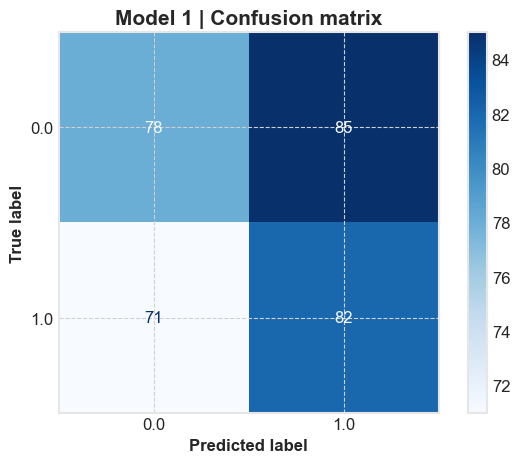

>> Model 1 | Out-Of-Sample (OOS) evaluation:
              precision    recall  f1-score   support

         0.0      0.523     0.479     0.500       163
         1.0      0.491     0.536     0.512       153

    accuracy                          0.506       316
   macro avg      0.507     0.507     0.506       316
weighted avg      0.508     0.506     0.506       316

    :::>>> OOS ROC-AUC of the model: 0.507


In [17]:
# 6) finding predictions on the testing set for Model 1
y_pre = bestModel1.predict(X_test)

# 7) computing Confusion Matrix for Model 1
plot_confusion_matrix(bestModel1, X_test, y_test.Label, cmap=plt.cm.Blues)
plt.title("Model 1 | Confusion matrix", weight='bold', size=15)
plt.tight_layout()
plt.show()

# 8) getting general OOS info
print(">> Model 1 | Out-Of-Sample (OOS) evaluation:")
print(classification_report(y_test.Label, y_pre, digits=3))
print(f"    :::>>> OOS ROC-AUC of the model: {round(roc_auc_score(y_test.Label, y_pre), 3)}")

There are several considerations about **Model 1** we can infer from these results. The not such bad things are the values chosen for the hyperparameters during the `GridSearch`; these are, more or less, what we expected: the tree did not ask for more depth (just `max_depth=6`), although we used `range(2, 10)` to test it. However, it is important to mention that this maximum depth of 6 is not optimal, since the model is working over $26$ observations as the minimum sample on each leaf. It is necessary that any new version of this model should reduce its depth for the same minimum observations per leaf. There is an identical but more interesting story related to `min_samples_split`: there is a huge probability that the model is overfitting because this hyperparameter has chosen the lowest minimum samples to split an internal node ($50$). It is correct to think that this value is appropiate anyway as our first approximation, but it should be increased for a new enhanced version of our model.

Nevertheless, there are some other evident drawbacks we can find from these results as well. The first thing is that our `IS ROC-AUC` of the best-estimator was about $0.54$. This is not a bad number by itself, but we should test it OOS. There, the `ROC-AUC` goes down to $0.507$; i.e., basically randomness. So, it is easy to conclude that the model may suffers from a low capacity to distinguish between labels. This can be confirmed as well with more specific metrics: for instance, the difference between the TP/TN values against its FN/FP respectively for each label is too little, which make us distrusts about the generalization capacity of the model. There is a similar story with the F1-score obtained per label: although f1-scores for each label indicates a balanced trade-off between precision and recall (`f1-score > 0.5`), the metrics described above tell us that our model is affected mostly by randomness. 

Hence, how should we proceed in order to improve these results? The answer to this question has to do with something different than the model by itself; i.e with the feautres involved.

#####  2.2.1.3. The colinear features, the feature correlation matrix and the model feature importance analysis

The main-step to achieve a model-improvement in ML is to "open the box"; that is, to try to interpret or understand the process done by the model given the base information. One of these base "commodities" that defines the model results are the features; perhaps, the most important one. The universe of feautres used during the training and testing could be problematic due to a certain phenomenon well-known as **colinear features**, also called **correlation bias** in the field of Statistics. This issue arise when a subset of features shares relevant predictive information. The inmediate consequence of this over any ML algorithm is defined as "_Substitution effect_" (see Lopez de Prado, 2018), a condition that makes that the importance of one feature being reduced by the presence of other related one. Mostly, this occurs at the moment when a ML algorithm is fed with a group of higly correlated features. The algorithm detects this condition in the learning process, and automatically set a huge weight to one arbitray representative of the group. However, this representation is not but defined randomly, so the ML algorithm will end up considering the other features as redundant, even if these could even be more significant relatively to the rest of the features. Hence, to a achive better marks in our new `DecisionTreeClassifier`, we should start by dealing with this problem.

Notice that a linear correlation is the simplest way to detect if a subset of features shares certain information (since it detects linear relationships), but it is not the only procedure. There are other ways to detect more complex, non-linear informative relationships (see Lopez de Prado, 2020) that could even be more important/detrimental to the model. However, these methods are out of the scope of this study.

Therefore, in this subsection, we will start by trying to understand this phenomenon in its simple form; i.e., by taking a look of the correlation featuers matrix, and the feature importance obtained in our first **Model 1**.

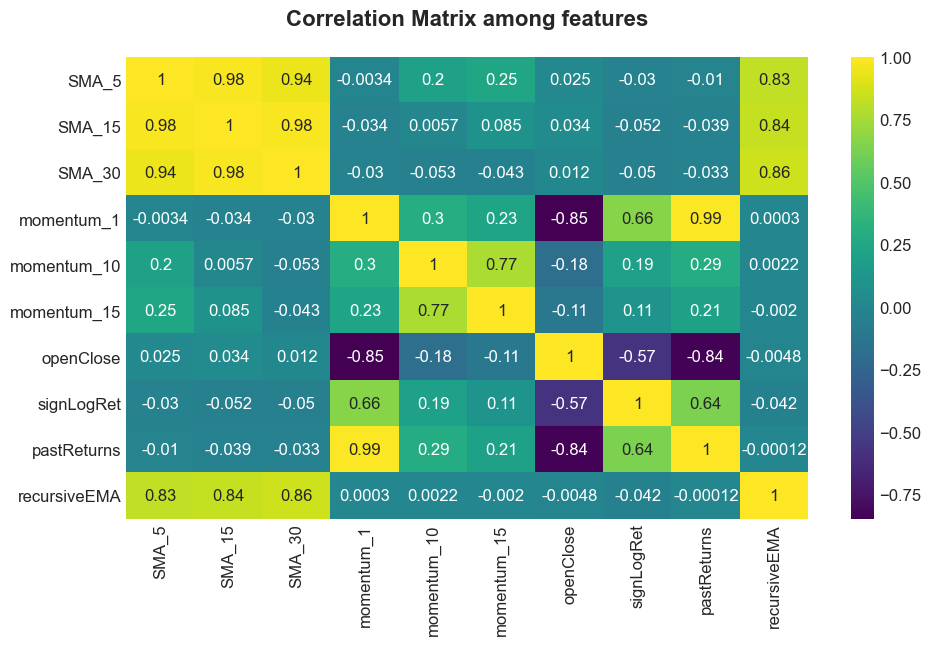

In [18]:
# first, let's compute the corr. matrix among features
corrFeatMatrix = featuresDf.corr()

##### >>> Plotting of features correlation matrix
plt.figure(figsize=(11,6))
sns.heatmap(corrFeatMatrix, cmap="viridis",annot=True)
plt.title(
    'Correlation Matrix among features', 
    fontsize=16, y=1.05, weight='bold'
)
plt.show()

Clearly, there are highly correlated features. So, we can define a reasonable discretionary value, say $\rho_{max} =\space^+_-\space0.70$, to identify those pairwise of features with a correlation above/below this threshold.

In [19]:
# setting correlation maximum threshold
rho_max = 0.70

# detecting pairwise features with abs(corr) > rho_max
idxPairwise = np.where(abs(corrFeatMatrix) >= rho_max)
lstPairwise = [
    [corrFeatMatrix.index[x], corrFeatMatrix.columns[y], round(corrFeatMatrix.iloc[x, y], 3)] 
    for x, y in zip(*idxPairwise) if x != y and x < y
]
print("::>> Pairwise features with 𝜌𝑚𝑎𝑥= +− 0.7 :")
print("::::>>>> List/list represents [Feat1, Feat2, Corr]:")
lstPairwise

::>> Pairwise features with 𝜌𝑚𝑎𝑥= +− 0.7 :
::::>>>> List/list represents [Feat1, Feat2, Corr]:


[['SMA_5', 'SMA_15', 0.978],
 ['SMA_5', 'SMA_30', 0.944],
 ['SMA_5', 'recursiveEMA', 0.825],
 ['SMA_15', 'SMA_30', 0.98],
 ['SMA_15', 'recursiveEMA', 0.841],
 ['SMA_30', 'recursiveEMA', 0.86],
 ['momentum_1', 'openClose', -0.847],
 ['momentum_1', 'pastReturns', 0.992],
 ['momentum_10', 'momentum_15', 0.766],
 ['openClose', 'pastReturns', -0.839]]

We can clearly distinguish two groups of highly corerlated features, and one pairwise. These are:

- `['SMA_5', 'SMA_15', 'SMA_30', 'recursiveEMA']`
- `['momentum_1', 'openClose', 'pastReturns']`
- `['momentun_10', 'momentum_15']`

These subsets represent the "_informational clusters_" of the linear relationships among features. So, we will use this information later on. By now, we are not going to eliminate or select one of them, since we need to understand two conditions before: 

* The **join effects and the hierarchical importance of the features**.

* The **singular importance of each feautre**. 

These methods evaluate two complementary topics respectively: the **influence of the features as a whole set of informative characteristics** to the model, and **the effects on the model of each feature in isolation**. This information, combined with our _linear informational clusters_, can lead us to identify a better subset of feautures that might ensure us an improvement in our model results.

Moreover, it is important to mention that the former condition can be evaluated directly from the model; the latter, using a similar base-estimator to understand the importance of each feature at a time. So, we will use two different methods: the **SHapley Additive exPlanations (SHAP)** for the join effects, and the **Single Feature Importance (SFI)** for the singular importance evaluation.

But, first, let's plot the underlying feature importances extracted from our **Model 1** as a general reference.

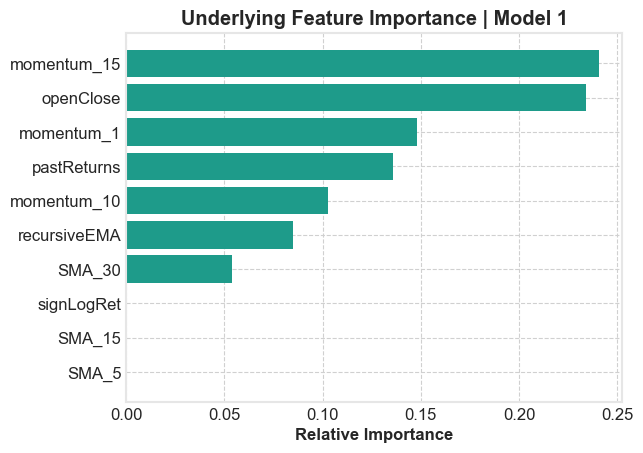

In [20]:
# plot the undetlying features importances 
importances = bestModel1.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.title('Underlying Feature Importance | Model 1', weight='bold')
plt.barh(range(len(indices)), importances[indices], color=(0.119512, 0.607464, 0.540218, 1.0), align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Now, we will use these importances to compare them agains the other two methods. 

#####  2.2.1.4. SHAP Method - Join Effects Evaluation

From the CQF lectures, we've learned that the SHAP is a game theoretic based approach that **evaluates the average marginal contribution of a feature value across all other possible features combinations** (called "coalitions"). So, it analyze the relative effect of each feature by comparing its impact against the average of the other features. This is important, since this procedure allow us to see whether the join effects of the basket of features are beneficial/detrimental in comparisson with each feature, and by how. Notice that **SHAP is mostly an in-sample procedure**, since we are using an already trained model to assess its features impact during its prediction. 

Moreover, it is important to mention that the SHAP method cannot deal with "_Substition effects_", since this procedure just follows the model's decision making-process—if the trainned model trusts arbitrarily, say, in one feature and not in the other because they are extremly correlated, the SHAP values for the first one will be greater, independently if the second feature could even be more significant or not. 

Hence, computing this method for our **Model 1** to get its SHAP feature importances, we can get: 

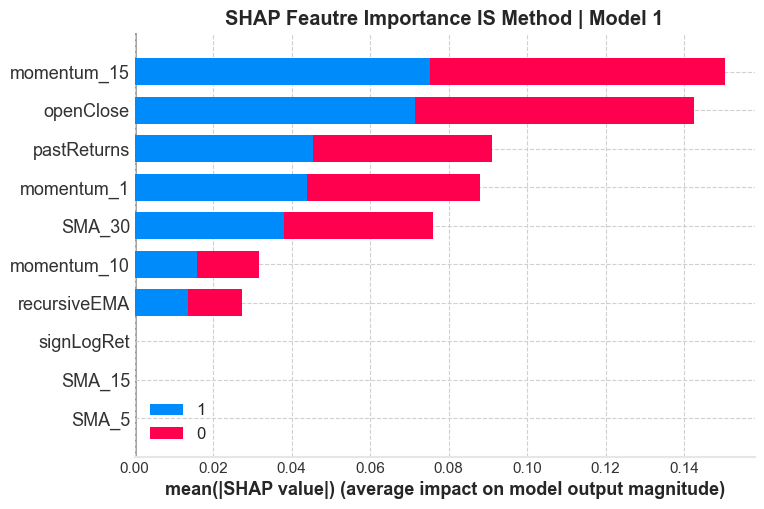

In [21]:
# defining a sample of 100 datapoints to serve as background dist
backDist = shap.utils.sample(X_train_f, 100, random_state=42)
# defining the SHAP tree explainer
explainer = shap.TreeExplainer(bestModel1, backDist)
# computing the SHAP values for each feature
shap_values = explainer.shap_values(X_train_f) 
# plotting the SHAP summary bar plot
shap.summary_plot(
    shap_values, X.values, 
    plot_type="bar", class_names= ["0", "1"], feature_names = X_train_f.columns, show=False
)
plt.title("SHAP Feautre Importance IS Method | Model 1", weight='bold')
plt.show()

We can deduce some important considerations from this results. The first thing is that the SHAP importance organization looks a little bit different than the deduced directly from the model; this is because the SHAP method weights the relevance of each feature in a different manner by computing its shaps values. Also, notice that the importance of the features `momentum_15` and `openClose` against the rest are very meaningful. So, at least one of them is a mandatory variable to be included in any reduced features dataset. However, notice the former has a high correlation with `momentum_10`, and the latter with `momentum_1` `pastReturns`. In fact, these three last features were ranked as well in the SHAP plot, but with much less importance. A more dramatic scenario occurs with `SMA_30`: since this feature is highly correlated with `recursiveEMA`, `SMA_5` and `SMA_15`, the first of these had a small importance compared to the other two that were not taken into account. Therefore, this proves that our model is suffering from _correlation bias_, some features are deteriorated by an evident _substitution effect_, and, thus, our SHAP evaluation may reflect these (not-fair) results. 

Hence, in order to complement this analysis, we will apply our next feature importance method. 

#####  2.2.1.5. Single Feature Importance - Features  in Isolation

The **SFI method is an OOS procedure proposed by Lopez de Prado (2018) to deal with _substition effects_ among features**. The algorithm is quite simple: 1) first, iterate over each feature at a time, selecting its values from the general features dataset; 2) feed a related empty classifier of interest with it, and compute its OOS score; 3) repeat this process for n-folds in a cross-validation process, saving the OOS score in each trial; and, finally, 4) compute the mean and the standard deviation of the set of metrics for the given feature over the n-folds. The mean value of  each feature is interpreted as its importance metric, and the absolute standard deviation, its inverse degree of confidence.

It is evident that the main drawback of this method is that it does not consider any join effect—it solves perfectly the _substition effects_ because it does not evaluate the whole features dataset. However, we already have the SHAP feature importance as a complementary metric to, with both, perform a better feature selection.

Thus, we will compute the SFI method and evaluate its `penalizedMean`, i.e., its mean importance value minus its absolute deviation. 

So, Defining a `SFI_CQF` function to pass our data, we get: 

In [22]:
# SFI method 
def SFI_CQF(clf, X, y, nSplits, label_name='Label', penalized=True):
    """
    Description:
        This function is an updated version of the method proposed by Lopez de Prado (2018),
        called Single Feature Importance, a Feature Importance Isolated OOS technique.
        This version apply some changes to be useful to our dataset in the context of the CQF.
    Methodology:
        The SFI OOS method evaluates the performance of a given single feature
        in a Naive Classifier (i.e., no tunned). So, each feature of the 
        general dataset will be tested independently, finding its score (here, accuracy),
        and return a dataframe with its OOS score mean value for all the 'nSplits'. 
        Also, the method returns the standard deviation of this mean, 
        and its 'penalized mean' if it is asked (penalized=True). 
    Input:
        - clf: classifier object to be used as the base estimator
        - X: pd.DataFrame with the features to be tested in isolation
        - y: pd.DataFrame with the labels; one column should be 'label_name'
        - nSplits: int with the total splits to be used per feature in the evaluation.
        - label_name: str containing the name of the label 
        - penalized: boolean activated if we want to find its penalized mean score by std.
    Output:
        - pd.DataFrame of columns:
            > "meanImportance"
            > "stdImportance"
            > "penalizedMeanImp"
          dataframe index := features name
    """
    # defining a empty importance dataframe
    importance = pd.DataFrame(columns=["meanImportance", "stdImportance"])
    # setting iteration per feature
    for feature in X.columns:
        # empty list to save the scores
        scores = []
        # definition of the temporal classifier to be updated at each new feature
        tempClf = clf
        # setting of the timeSeriesSplit object with the Number of Splits
        tscv = TimeSeriesSplit(n_splits=nSplits)
        # selecting the temporal dataframe with only the feature of the iteration
        temporalX = X[[feature]]
        # split given the temporal features dataset 'temporalX' with only one feature
        for train_index, test_index in tscv.split(temporalX):
            # feature training and testing set definition
            tempXTrain, tempXTest = temporalX.iloc[train_index], temporalX.iloc[test_index]
            # label training and testing set definition
            tempYTrain, tempYTest = y[label_name].iloc[train_index], y[label_name].iloc[test_index]
            # fitting the classifier with the temporal training dataset 
            fit = tempClf.fit(tempXTrain, tempYTrain)
            # computing the prediction using OOS test data
            pred = fit.predict(tempXTest)
            # finding the OOS score (fixed metric: accuracy) and appending its value
            score_ = accuracy_score(tempYTest, pred)
            scores.append(score_)
        # filling the dataframe with the results for the given feature
        importance.loc[feature, 'meanImportance'] = np.array(scores).mean()
        importance.loc[feature, 'stdImportance'] = abs(np.array(scores).std())         
        importance.loc[feature, 'penalizedMeanImp'] = \
        importance.loc[feature, 'meanImportance'] - importance.loc[feature, 'stdImportance']
    return importance

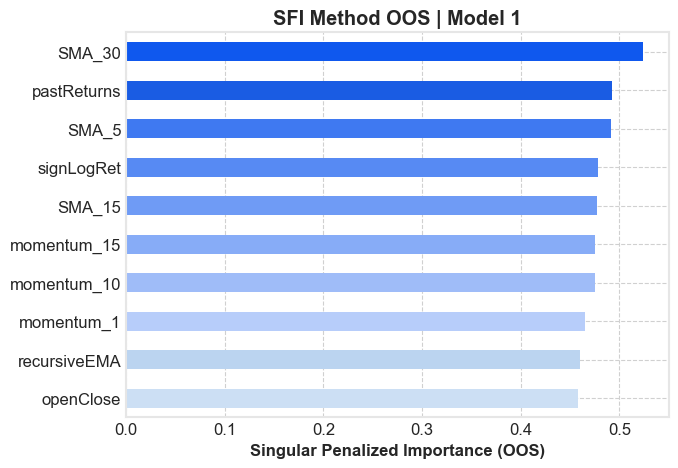

In [23]:
# computing SFI importance method over an empty Decision Tree Classifier
sfi_imp = SFI_CQF(DecisionTreeClassifier(), X, y, 5, label_name='Label', penalized=True)

# plotting its SFI importances from the 'penalizedMeanImp'
sfi_imp[['penalizedMeanImp']].sort_values('penalizedMeanImp').plot.barh(
    color={'penalizedMeanImp':[
        '#CCDFF4', '#BBD4F0', 
        '#B7CDFA', '#9FBCF8', 
        '#87ACF7', '#6F9BF5', 
        "#578AF3", "#3F79F1", 
        "#1A5CE3", '#0F58EE'
    ]}, 
    figsize=(7,5), legend=False,
)
plt.title("SFI Method OOS | Model 1", weight='bold')
plt.xlabel('Singular Penalized Importance (OOS)')
plt.show()

There is a remarkable discovery we can describe here: the feature `SMA_30`, which seemed to be a second-order variable in the SHAP Feature Importance method, has a significant predictive power _in isolation_ for a naive Decision Tree model. This is insightful, since we have been able to rescue this important feature affected by its _substition effect_. Thus, since this is our best 'isolated variable', we can say this is also a mandatory feature to be used in any further dataset. Moreover, notice that `pastReturns` is, perhaps, the best balanced feature since it contains a significant importance _in isolation_, as well as a _in collectivity_ based on the SHAP results. Another important consideration is that the feature `openClose`, which was weighted as the second best variable in the SHAP method, is considered by the SFI method as the _worst_ feature _in isolation_. We can easly conclude that `openClose` is powerful only in collectivity, so it depends mostly on the _join effects_ with other feature or subset of features. We might assume that the negative correlation of this with `pastReturns` could make them a pairwise more robust (since both were considered in the SHAP method as well), so we decide to include them. We cannot say something similar with respect to `momentum_15`: since it seems to be the best in collectivity, it is difficult to assume to which set of features could achieve more significant relevance because it is only correlated to `momentum_10`, another feature difficult to explain with the methods above. Thus, we decide to drop these two by now. 

In that sense, we will work over `SMA_30`, `pastReturns` and `openClose`. Furthermore, it is important to mention there are more elements to evaluate of the rest of features, in which, as we said, the comparative scenarios are more complex. For instance, we can propose an orthogalization to them to reduce its _substitution effects_, and run again the SHAP method to evaluate its differences. Another alternative is to apply a ML clusterization among features, trying to find out not just linear-informational clusters, but more complex ones (e.g., distinguishing between noise and signal on each of them), and applying SHAP or SFI in each of them. Also, there are other methods (see Lopez de Prado, 2018), such as Mean Decrease Accuracy (MDA) or Mean Decrease Impurity (MDI) that we can afford as well. Nevertheless, this extended work is out of the scope of this study. 

In the next section, we will put in practice the subset of features selected above.

#####  2.2.1.6. Model 2 (just important features)

Finally, we are able to compute our new `DecisionTreeClassifier` using oue new subset of features. This new model will run a `GridSearch` again to see if these new features changes the optimal hyperparameters for the tree. However, it will still use the same `grid_dictionary`; i.e., the same universe of values will be tested to avoid any bias between models.

Hence, using the following features:

`[SMA_30, pastReturns, openClose]`

We can get:

In [24]:
# defining list of more relevant features
relevantFeatures = ["SMA_30", "openClose", "pastReturns"]

# reducing only to relevant features in the features training and testing dataset
new_X_train_f = X_train_f[relevantFeatures]
new_X_test = X_test[relevantFeatures]

In [25]:
# 1) defining base DecisionTree Classifier for Model 2 (random state = 0)
model2 = DecisionTreeClassifier(min_samples_leaf=26, random_state=0)

# 2) defining Grid Search CV object
model2_grid = GridSearchCV(
          estimator = model2, 
          param_grid = grid_dictionary, # the same gridSearch dict as Model 1
          cv = TimeSeriesSplit(n_splits=5),
          verbose=2,  
          n_jobs = -1, 
          scoring="roc_auc" # the same score as Model 1 
      )

# 3) running the Grid Search CV using the fixed training data sorted by time
#    this is important since it's necessary for the `TimeSeriesSplit` implementation
model2_grid.fit(new_X_train_f, y_train_f.Label)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeClassifier(min_samples_leaf=26,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 11),
                         'min_samples_split': range(50, 105, 5)},
             scoring='roc_auc', verbose=2)

:::>>> Model selected during the GridSearch:
       >> Model 2:  DecisionTreeClassifier(max_depth=5, min_samples_leaf=26, min_samples_split=70,
                       random_state=0)
       >> Best score IS (ROC-AUC):  0.556 

:::>>> Model 2 tree structure:


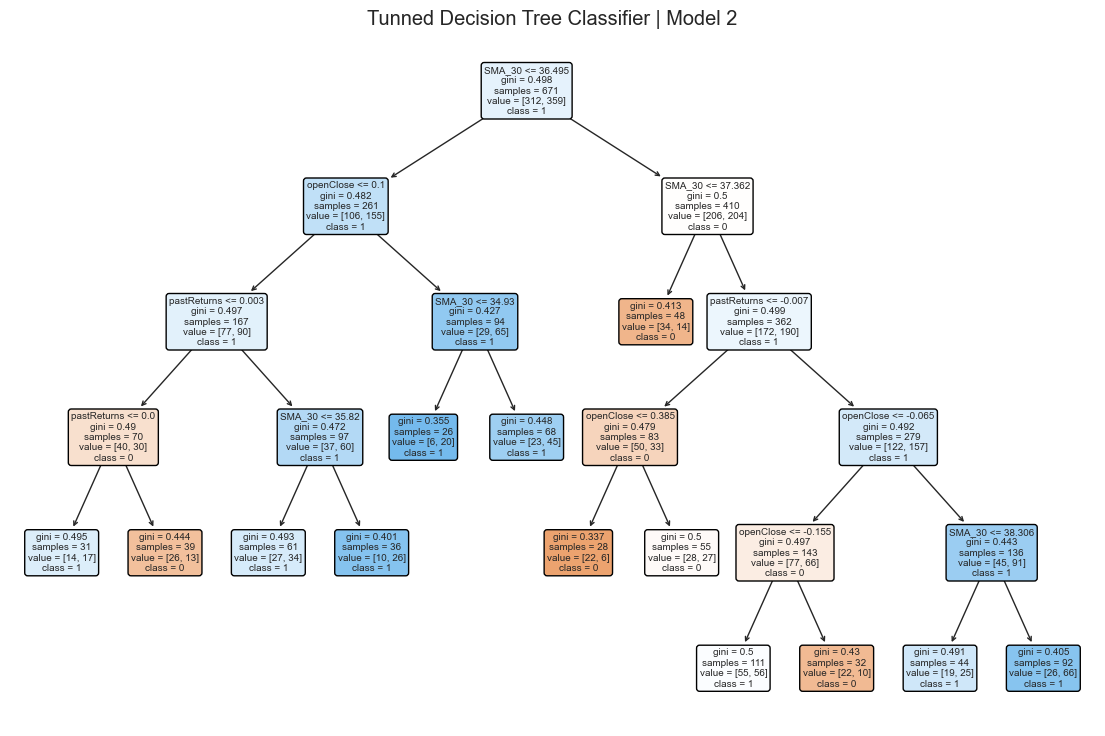

In [26]:
# 4) selecting best Model 2 from the GridSearch, printing its training score and plotting its structure
bestModel2 = model2_grid.best_estimator_
print(":::>>> Model selected during the GridSearch:")
print("       >> Model 2: ",bestModel2)
print("       >> Best score IS (ROC-AUC): ",round(model2_grid.best_score_,3), "\n")
print(":::>>> Model 2 tree structure:")
# plotting the tree
plt.figure(figsize=(14,9))
tree.plot_tree(
    bestModel2, filled=True, rounded=True, 
    class_names=["0", "1"], feature_names=relevantFeatures
)
plt.title("Tunned Decision Tree Classifier | Model 2")
plt.show()

Finally, we can get the OOS evaluation for **Model 2**, such as:

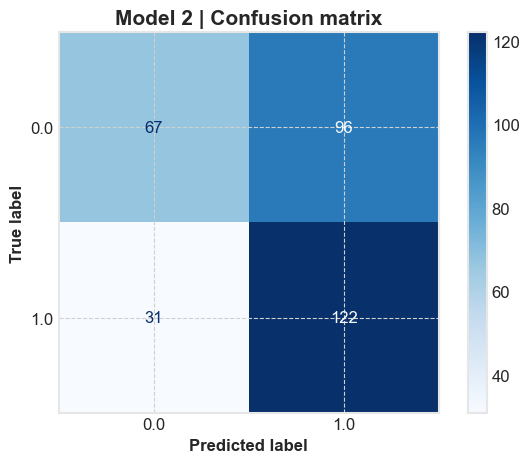

>> Model 2 | Out-Of-Sample (OOS) evaluation:
              precision    recall  f1-score   support

         0.0      0.684     0.411     0.513       163
         1.0      0.560     0.797     0.658       153

    accuracy                          0.598       316
   macro avg      0.622     0.604     0.586       316
weighted avg      0.624     0.598     0.583       316

    :::>>> OOS ROC-AUC of the model: 0.604


In [27]:
# 6) finding predictions on the testing set for Model 2
y_pre = bestModel2.predict(new_X_test)

# 7) computing Confusion Matrix for Model 1
plot_confusion_matrix(bestModel2, new_X_test, y_test.Label, cmap=plt.cm.Blues)
plt.title("Model 2 | Confusion matrix", weight='bold', size=15)
plt.tight_layout()
plt.show()

# 8) getting general OOS info
print(">> Model 2 | Out-Of-Sample (OOS) evaluation:")
print(classification_report(y_test.Label, y_pre, digits=3))
print(f"    :::>>> OOS ROC-AUC of the model: {round(roc_auc_score(y_test.Label, y_pre), 3)}")

Clearly, we can see significant improvements in **Model 2**. First, there is a reduction in 'depth': we went from $6$ in **Model 1** to $5$ in this new model. In this fashion, our In-Sample score (ROC-AUC) increased a little bit, going from $0.54$ in **Model 1** to $0.556$ in **Model 2**, which, together with the reduction in depth, could mean a less probability of overfitting during the training process. We can confirm this by the OOS ROC-AUC: it is now $0.604$. Furthermore, other significant change was the increment of the minimum samples required to split an internal node: we went from $50$ to $70$ in this new **Model 2**. This important, because, together with the increment in the OOS ROC-AUC, indicates our new model would be a little further from randomness. Similarly, the rest of the metrics were improved as well: we went from an F1-score of $0.50\text{-}0.512$ in **Model 1** to $0.513\text{-}0.658$ in **Model 2** for label 0 and 1 respectively, being the latter the most well-learned class. Hence, in general, we can say that we achieved a decent improvement in our marks by only selecting an appropiate reduced set of features. 

#### 2.2.2. Formulate up to four principles/purposes of trees pruning for Model 1 & Model 2 (POINT 2)

From the CQF lectures, we learned that prunning is, perhaps, the most important technique to overcome the issue of overfitting in the context of Decision Tree models. In a brief, "prunning" refers to the process of delete the unnecesary parts of our tree model; particularly, the method focuses on the removal of nodes/leaves that may be detrimental to the generalization power of our model. Normally, there are two types of prunning methods we can afford: _forward prunning_ and _backward prunning_. In this section, we will basically elaborate principles of the former based on what we already did in the previous step, but we are going to give some basic insights about the latter as well to understand its differences.

##### 2.2.2.1. Prunning Principles 

There are several principles of prunning that can even be extended to specific ML applications. Here, we will just define $3$ of them based on what we did in the section above (specifically, in section "_2.2.1.1. The values for the hyperparameters_"). 

So, these principles are:

- **Principle 1: elaborate a solid data-driven criteria to impose a minimum number of samples per leaf as a first step**

This is the most important principle, because this hyperparameter may help us in the definition of the other two involved in our prunning goal. In particular, we explained that `min_samples_leaf` is crucial since it has a "_triple trade-off_" (see section 2.2.1.1) with `max_depth` and `min_samples_split`, the other relevant hyperparamters. Thus, it is necessary to set a "formulae" (statistically, mostly) for, given the size and properties of our dataset, discover how many samples we need at least as a reference for each leaf. Instead of setting a set of arbitrary numbers in the `GridSearch`, we consider it is always better to analyze our dataset, the number of "hits" of our target-variable of interest (e.g., in our case, label 1), and get a decent proportion of how many samples we need. In this case, we decided to work using the **Margin Error (ME)** (see section 2.2.1.1.) for a given confidence interval based on our dataset observations; but other approaches are valid as well. The advantage of this approach is that it is model-independent, since we are looking for the number of samples we need to get more than 50/50 observations for the label of interest based on the information we have in our dataset. Also, even in the `GridSearch` step, we could see our models do not ask for more depth, even though we define `min_samples_leaf = 26` rigorously for both of them. We consider this is as a good signal that our estimated value of $26$ seems sensible. Hence, to sum up, any data-driven approach could be considered feasible to test and find a reference of the minimum number of samples per leaf necessary to build a reasonable estructure in our Decision Trees, preventing any issue by setting this value and stopping the non-significant nodes-branches from generating (i.e., by prunning it).

- **Principle 2: the minimum samples to split an internal node should be greater than the samples required per leaf, but not by too much**

This second principle is related to the "rule of thumb" we used before: since we are trying to reduce the chance of overfitting by finding a significant (but not extreme) number of samples per leaf, it is pretty obvious that we also need a greater value for the minimum samples to split an internal node. If we set it using any value below the number of samples in a leaf, it would not make any sense because, by nature, there should be more observations to split a node rather than in potential final leaves. Being saying that, how greater this value should be? Since we are using a data-driven method to find out the minimum samples per leaf (another reason about the importance of **Principle 1**), we can take the liberty of use a simple rule such as two times the minimun samples per leaf. In our case, this lead us to start from $50$ to any sensible range of greater values in the context of our `GridSearch`. However, generally speaking, if there is a huge difference in scale between the number of samples per leaf and this value, the tree will simply ignore any sample requirement to split an internal node, which means basically this will become an unnecesary variable by itself. Thus, this value should be greater than `min_samples_leaf`, but not by too much. Sounds intuitive, but finding this "optimal" value is more complex and requires an understanding of the scheme of the tree (i.e., there is no a model-independet approach). This is why we just simply set a range of values greater than our minimum samples per leaf, trusting more in our **Principle 1**.

- **Principle 3: we should control the max depth of our tree, while remaining flexible due to the 'features factor'**

The criteria of this third principle is very similar to the above, but in the opposite direction: we _must_ control the depth of our tree, but, due to this "_triple trade-off_" (see section 2.2.1.1.), we should allow it to _explotes_ its capacity to fit the data only if it is controled by the `min_samples_leaf` already defined. In this context, we tend to believe that, given a decent number of samples per leaf, the tree would not ask fore more depth (i.e., to be more "fitted" to our data) and, thus, the risk of overfitting would decrease. Nevertheless, the depth of the tree might change among its configurations: not just because we set different values for the other hyperparameters, but due to the nature of the data we are using; e.g., **Model 2** requires less depth since we _reduced_ the features involved in **Model 1**, even though both of them used the same minimum value of samples per leaf. This is crucial, because this indicates there might be a relationship between the features involved and the depth required for a tree. This 'features factor' can make us to think about an increasing or decreasing of the depth of the tree based on the features used. For instance, if we have a dataset with $100$ useful features, should a depth between $3$-$5$ be appropiate? Maybe not: not just because there are a lot of features, but due to probability that these depth values can capture the influence of most of the features in a healthy tree-structure with a sensible depth. Thus, this is why we consider that, even to the aim of a more accurate prunning task, we should restrict the maxmimum depth of a tree, but without losing the criteria of what we are using as our main predictive variables in our model. This is the reason why in both models we set a range of depth between $0$-$10$ during our `GridSearch`, consideraing we will get a decent value for it trusting more in our **Principle 1**.

Finally, it is important to mention that we will not "prunne" here again defining `min_samples_leaf = 26` in a `GridSearch` for **Model 2**, as well as in section 2.2.1.6., because we already did it.

Being saying that, the principles defined above are part from what we know as _forward prunning_. Normally, this type of prunning is done _before_ the construction of the model, because we need to pass several constraints in the form of values for the hyperparameters described above, seeking for a stop of the non-significant branches from generating. The main technique is the _hyperparameter tuning_ (i.e., the uses of `GridSearch` or `RandomizedGridSearch` for a basket of values for each hyperparamter). This is exactly what we have done in section 2.2.1. by defining our criteria to restrict the values for our hyperparameters, following the principles described here to be more reliable in our results. 

In other hand, there is another type of prunning called _backward pruning_. Typically, this type of prunning starts by training a naive Decision Tree without restrictions, and then start prunning its unnecesary nodes by evaluating its costs of complexity, looking for the parameters (`cc_alpha`, specifically) that could lead us to the best OOS score. Since the exam focuses more on the first type of prunning, this second method is out of the scope of this study.

#### 2.2.3. Provide attribution to splits, particularly for Model 2 

From the CQF lectures, we learned that a decision tree is composed by nodes which represents attributes (features); these are connected by branches (links), defined as _decision rules_ that allows the separation; the final outcome of this structure is a leaf, which represents an specific class/value. The aim of any tree is to create an structure based on well-separable attributes and well-defined classes/values in its nodes and leaves respectively. So, the tree tends to pick up the attributes that make its structure more "pure"; i.e., the feature/s that improves homogeneity among nodes. Since the tree is constantly seeking "purity", each new level/node is suppose to aggregate ("gain") more information with respecto to the previous one. In the context of classification tasks, the tree finds the entropy of each node as a metric of how pure/impure it is based on the attributes involved in its division and the consecuent well-defined classes/values on its child-nodes or leaves. The difference between the current entropy and the ones after the split (i.e., its impurity reduction) is defined as _information gain_; if this value is significant, the splitting is allowed. 

Thus, being saying that, there are several common prodecures to stop the splitting process, since no-more informational gain could be achieved (and, thus, no more nodes are needed). The first thing is to set an specific maximum depth for our tree. Since we already did this by finding that `max_depth=5`, there are other alternatives. The most common next step is to **_impose a minimum gain expected for each new split_**. So, if there is a reduction in the impurity after the split that is below this threshold, the split will not be implemented. In that sense, the loss function (particularly, our Gini Impurity Index) will be forced to penalized those nodes/leaves which do not differ too much from the previous split, avoiding them to appear.

So, since the aim of this section is to try to improve negatives moves classification (label 0), and being **Model 2** our best tree, we can start from its structure by testing several values for the hyperparameter `min_impurity_decrease`. This value will restrict the nodes able to split to those that guarantees an impurity reduction greater than or equal to this value. Notice that our **Model 2** currently is better than **Model 1** classifying label 0, since the former effectively achieve greater TN than FN by just selecting the appropiate subset of features. However, we will try to push it to the limit by trying this experiment, and draw some conclusion from it. 

Therefore, say we will use the following min impurity thresholds:

`min_impurity_decrease = [0.0, 0.00025, 0.0005, 0.00075, 0.001, ..., 0.01]`

We will compare its OOS metrics to see different results. Particularly, we will use `F1 score` for label 0 and label 1 to distinguish how they move by applying our set of minimum impurity values. We expect an improvement in this score for label 0, considering the other metrics as well (accuracy and ROC-AUC).

Thus, applying this criteria, we can get:

In [28]:
# definition of minimum impurity values
impurity_thresholds = np.arange(0, 0.01025, 0.00025)

# definition of empty dictionary to save our results
modelImpurities1 = {}

# iteration per impurity value
for impurity in impurity_thresholds:
    
    # definition of our Model 2.1 
    model2_1 = DecisionTreeClassifier(
        max_depth=bestModel2.max_depth, # same maximum depth as Model 2
        min_samples_leaf=bestModel2.min_samples_leaf, # same min samples leaf as Model 2
        min_samples_split=bestModel2.min_samples_split, # same min samples split as Model 2
        min_impurity_decrease=impurity # definition of our impurity value
    )
    # fitting Model 2.1.
    model2_1.fit(new_X_train_f, y_train_f.Label)
    # OOS prediction of Model 2.1.
    y_pre21 = model2_1.predict(new_X_test)
    
    # computing OOS metrics for Model 2.1.
    generalAccuracy = round(accuracy_score(y_test.Label, y_pre21), 4)
    generalRocAUC = round(roc_auc_score(y_test.Label, y_pre21), 4)
    f1scorePerLabel = f1_score(y_test.Label, y_pre21, average=None)
    
    # saving results of Model 2.1. in the dictionary
    modelImpurities1[impurity] = [generalAccuracy, generalRocAUC, f1scorePerLabel, model2_1]

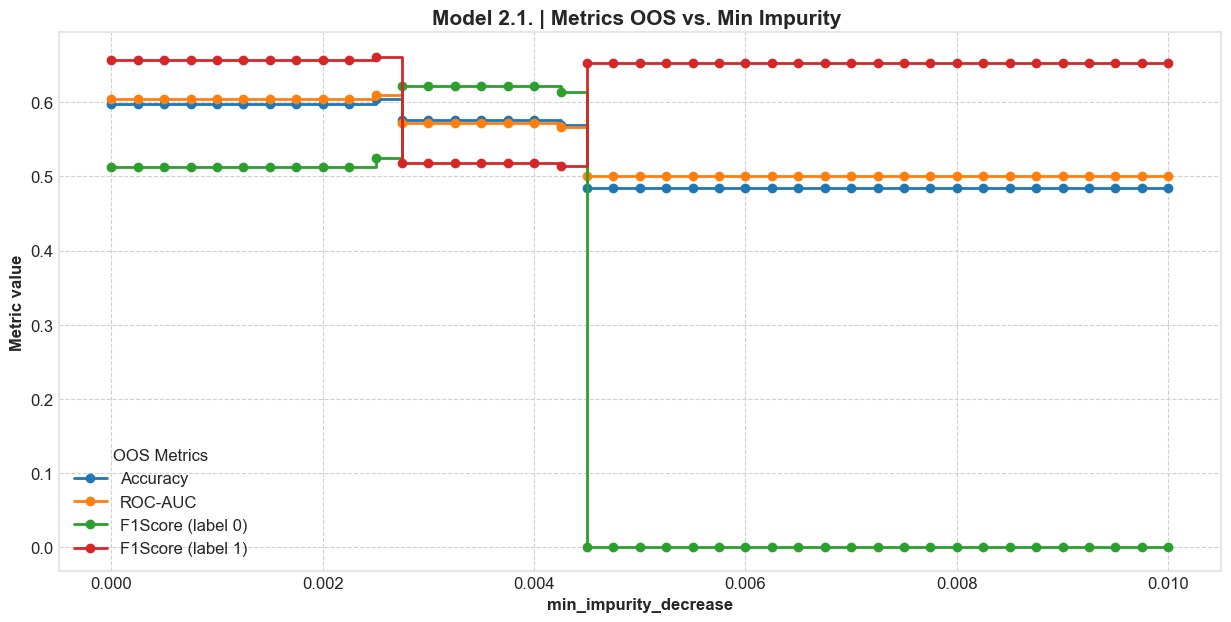

In [29]:
# plotting the OOS metric results we get from Model 2.1.
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel("min_impurity_decrease")
ax.set_ylabel("Metric value")
ax.set_title("Model 2.1. | Metrics OOS vs. Min Impurity ", weight='bold', size=15)
ax.plot(
    impurity_thresholds, 
    [element[0] for element in modelImpurities1.values()], 
    marker="o", label="Accuracy", drawstyle="steps-post"
)
ax.plot(
    impurity_thresholds, 
    [element[1] for element in modelImpurities1.values()], 
    marker="o", label="ROC-AUC", drawstyle="steps-post"
)
ax.plot(
    impurity_thresholds, 
    [element[2][0] for element in modelImpurities1.values()], 
    marker="o", label="F1Score (label 0)", drawstyle="steps-post"
)
ax.plot(
    impurity_thresholds, 
    [element[2][1] for element in modelImpurities1.values()], 
    marker="o", label="F1Score (label 1)", drawstyle="steps-post"
)
ax.legend(title="OOS Metrics")
plt.show()

Essentially, we can see a some changes between the F1-score of label 0 vs label 1 as long as we increase the value of the hyperparameter `min_impurity_decrease`. This metric was improved for label 0 when `0.00225 < min_impurity_decrease < 0.00425` more or less. However, at the same range, there is a detrimental for the F1-score of label 1, as well as with respect to the other metrics. Also, when `min_impurity_decrease>0.00425`, the model basically lost the capability to predict label 0 since its F1 score becomes 0. This is due the fact we overstress the model in such a way we ask for too much impurity reduction between each node and the next split, so the tree prefers to avoid to predicting label 0 because it is the class that learned the least. Moreover, notice that, when `min_impurity_decrease < 0.00225`, **Model 2.1.** is essentially the same as **Model 2**. This is very informative, because this means our best **Model 2** works in a range of impurity reduction per splitted node between that range. Nevertheless, we can see a small but interesting positive change in all OOS metrics when `min_impurity_decrease=0.0025`. Here:

In [30]:
# definition of impurity special case
specialCase = modelImpurities1[0.0025]
print(f">>> Model 2.1. special case | Minimum impurity reduction at '{0.0025}' leads to:")
print(f":::>>> OOS Accuracy: {specialCase[0]}")
print(f":::>>> OOS ROC-AUC: {specialCase[1]}")
print(f":::>>> OOS F1-Score per label: {specialCase[2]}")
print(f":::>>> Config.: {specialCase[3]}")

>>> Model 2.1. special case | Minimum impurity reduction at '0.0025' leads to:
:::>>> OOS Accuracy: 0.6044
:::>>> OOS ROC-AUC: 0.6103
:::>>> OOS F1-Score per label: [0.52471483 0.66124661]
:::>>> Config.: DecisionTreeClassifier(max_depth=5, min_impurity_decrease=0.0025,
                       min_samples_leaf=26, min_samples_split=70)


We can notice that, by defining `min_impurity_decrease=0.0025`, our new **Model 2.1.** went from an OOS ROC-AUC of $0.604$ to $0.6103$, as well as from an OOS accuracy of $0.598$ to $0.6044$; the same story with the F1-scores, wich now are a little bit better for each label. Defintely, these increments are relatively marginal, considering that label 0 is still the less well-predicted class, so maybe we can try something extra before take a decision. In that sense, we can invert the weights of our classes. We know that $53.50\%$ and $46.50\%$ of our training observations belongs to label 1 and 0 respectively. They are well-balanced; however, we can put more emphazise on label 0, since we want to improve its predictability. Therefore, we can set `class_weight = {1:0.47, 0:0.53}` as our new hyperparameter.

Thus, running again our experiment, we can get:

In [31]:
# definition of empty dictionary to save our results
modelImpurities2 = {}

# iteration per impurity value
for impurity in impurity_thresholds:
    
    # definition of our Model 2.2 weighted version 
    model2_2 = DecisionTreeClassifier(
        max_depth=bestModel2.max_depth, # same maximum depth as Model 2
        min_samples_leaf=bestModel2.min_samples_leaf, # same min samples leaf as Model 2
        min_samples_split=bestModel2.min_samples_split, # same min samples split as Model 2
        min_impurity_decrease=impurity, # definition of our impurity value
        class_weight={1:0.47, 0:0.53} # our new class weight definition
    )
    # fitting Model 2.2. weighted version
    model2_2.fit(new_X_train_f, y_train_f.Label)
    # OOS prediction of Model 2.2. weighted version
    y_pre21 = model2_2.predict(new_X_test)
    
    # computing OOS metrics for Model 2.2. weighted version
    generalAccuracy = round(accuracy_score(y_test.Label, y_pre21), 3)
    generalRocAUC = round(roc_auc_score(y_test.Label, y_pre21), 3)
    f1scorePerLabel = f1_score(y_test.Label, y_pre21, average=None)
    
    # saving results of Model 2.2. weighted version in the dictionary
    modelImpurities2[impurity] = [generalAccuracy, generalRocAUC, f1scorePerLabel, model2_2]

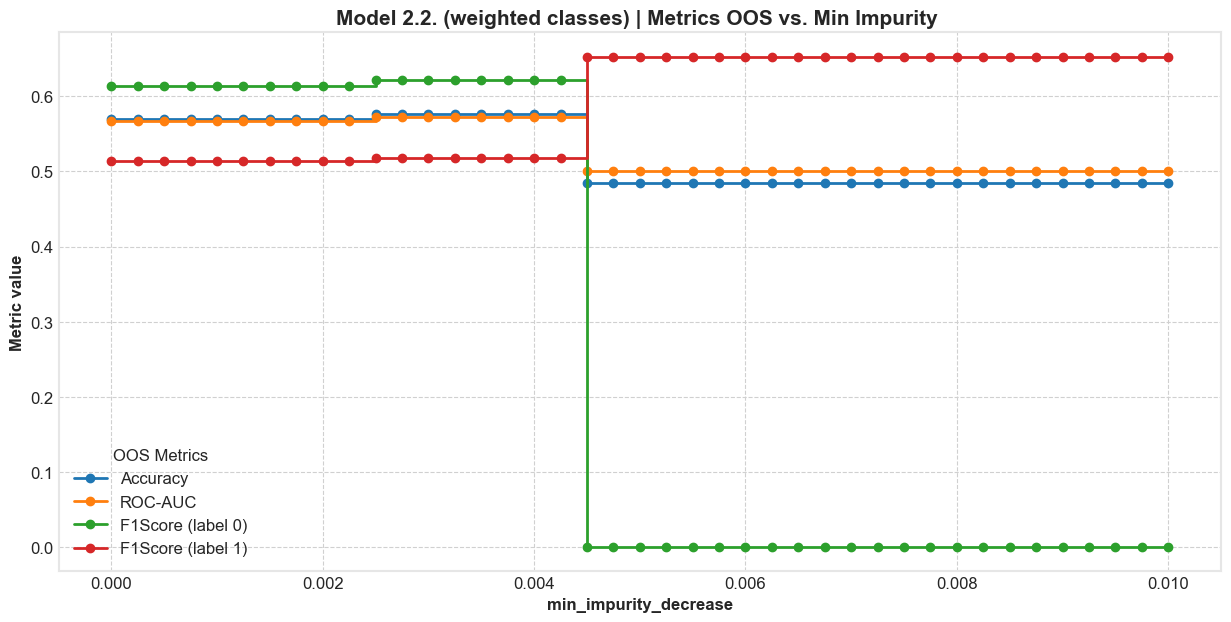

In [32]:
# plotting the OOS metric results we get from Model 2.2. weighted version
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel("min_impurity_decrease")
ax.set_ylabel("Metric value")
ax.set_title("Model 2.2. (weighted classes) | Metrics OOS vs. Min Impurity ", weight='bold', size=15)
ax.plot(
    impurity_thresholds, 
    [element[0] for element in modelImpurities2.values()], 
    marker="o", label="Accuracy", drawstyle="steps-post"
)
ax.plot(
    impurity_thresholds, 
    [element[1] for element in modelImpurities2.values()], 
    marker="o", label="ROC-AUC", drawstyle="steps-post"
)
ax.plot(
    impurity_thresholds, 
    [element[2][0] for element in modelImpurities2.values()], 
    marker="o", label="F1Score (label 0)", drawstyle="steps-post"
)
ax.plot(
    impurity_thresholds, 
    [element[2][1] for element in modelImpurities2.values()], 
    marker="o", label="F1Score (label 1)", drawstyle="steps-post"
)
ax.legend(title="OOS Metrics")
plt.show()

This **Model 2.2.** show us different considerations. For instance, the OOS accuracy decreases to $0.57$, a detrimental effect relative to what we got before. It is true that the F1-score of label 0 is greater now, but at the cost that label 1 is our new least learned class. Moreover, it is not stable, since when `min_impurityt_decrease > 0.00425` everything looks pretty similar to **Model 2.1.** in the same range of values. However, maybe the most interesting discovery could be that, at the same `min_impurity_decrease=0.0025`, there is a miniscule (but striking) improvement in all the metrics. This lead us to conclude that, in general, a value of `0.0025` for an impurity reduction constraint seems sensible.

Therefore, given the structure and weights of our best model (**Model 2**), we may ask: **is it sensible to introduce the hyperparameter `min_impurity_decrease` as an improvement criteria to our splitting process? Answer seems to be yes**, particularly in the special case `min_impurity_decrease=0.0025`. Again, the improvements achieved by introducing this hyperparameter are relative small, but, since we believe this does not affect the results of **Model 2**, making them a little bit better, we can consider to use the configuration of **Model 2.1** as our new best estimator.

Finally, in the next section we will address the details about the prediction quality for both **Model 1** and **Model 2**.

#### 2.2.4. Provide plots for decision boundaries, and name two specific issues for prediction quailty. 

Here, we will assess the issues in the prediction task faced with **Model 1** and **Model 2.1.**. But, first, let's plot its decision boundaries and ROC curves for both classes.

In [33]:
# let's compute a function to plot pairwise surfaces
def plot_pairwise_surfaces(
    model, X_data, y_data, list_features, model_name, 
    plot_colors=['red', 'green'], standarization = True, 
    plot_step = 0.02, cmap=plt.cm.Set3, left=0.1, bottom=0.1, right=0.9, 
    top=0.9, wspace=0.4, hspace=0.4, general_figsize=[14, 8], vsubplots=2, 
    hsubplots = 3, bbox_to_anchor=(1.025, 1.025)
    ):
    """
    Description:
        General function to plot decision boundaries/surfaces of any ML model.
        This was a personalized version developed based on the Sickit Learn general version:
        https://scikit-learn.org/0.15/auto_examples/tree/plot_iris.html 
    
    Methodology:
        This function implements a pairwise combination of all features
        as a visual representation for decision boundaries.
        This procedure is advisable only for 10 features at most. 

    Input (main):
        model: sklearn object (classifier). Should be ingested with all of its hyperparameters.
        X_data: features pd.Dataframe. Sorted by time.
        y_data: labels pd.Dataframe. Sorted by time. (only one column and same index as X_data)
        list_features: list of name of features using for the computation 
        model_name: str representing the name of the model.

    Output:
        Decision boundaries plot given the subplots coordinates.
    """
    # definition of how many classes we are dealing with
    n_classes = y_data.unique().shape[0]
    
    # check if there are same # colorplots as classes
    assert len(plot_colors) == n_classes, \
    ":::>>> There should be same same colors to plot as classes."
    
    # definition of pairwise features
    pairwiseFeatures = list(map(list, list(itertools.combinations(list_features, 2)))) 
    
    # define general subplot grid 
    fig = plt.figure(figsize=(general_figsize[0],general_figsize[1]))
    
    # iteration over each pairwise feature
    for pairidx, pairFeature in enumerate(pairwiseFeatures): 
        
        # get the pair location in our dataset
        pair = [X_data.columns.get_loc(feat) for feat in pairFeature]

        # taking the corresponding features and transforming X to np.array
        X = X_data.iloc[:, pair].values
        y = y_data.values

        # standarization of our features for further plot convenience
        if standarization:
            mean = X.mean(axis=0)
            std = X.std(axis=0)
            X = (X - mean) / std

        # training our classifier 
        clf = model.fit(X, y)

        # make the base subplot of our decision boundary
        ax = fig.add_subplot(vsubplots, hsubplots, pairidx + 1)
        
        # definition of our meshgrid (obs. boxes)
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # prediction of our model based on our meshgrid
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = ax.contourf(xx, yy, Z, cmap=cmap)
        
        # defining our axes
        ax.set_xlabel(X_data.columns[pair[0]])
        ax.set_ylabel(X_data.columns[pair[1]])

        # plot over the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            ax.scatter(X[idx, 0], X[idx, 1], c=color, label=str(int(y_data.unique()[i])))
            
    if model_name==None: model_name="Model"
    # returning final plot
    plt.subplots_adjust(left=left, bottom=bottom, right=right, 
                            top=top, wspace=wspace, hspace=hspace)    
    fig.suptitle(f"{model_name} | Pairwise Decision Boundaries (surfaces)")
    fig.tight_layout(pad=1.5)
    plt.legend(title = "Labels", bbox_to_anchor=bbox_to_anchor, title_fontsize='large')
    plt.show()

Thus, for **Model 1**, we can get:

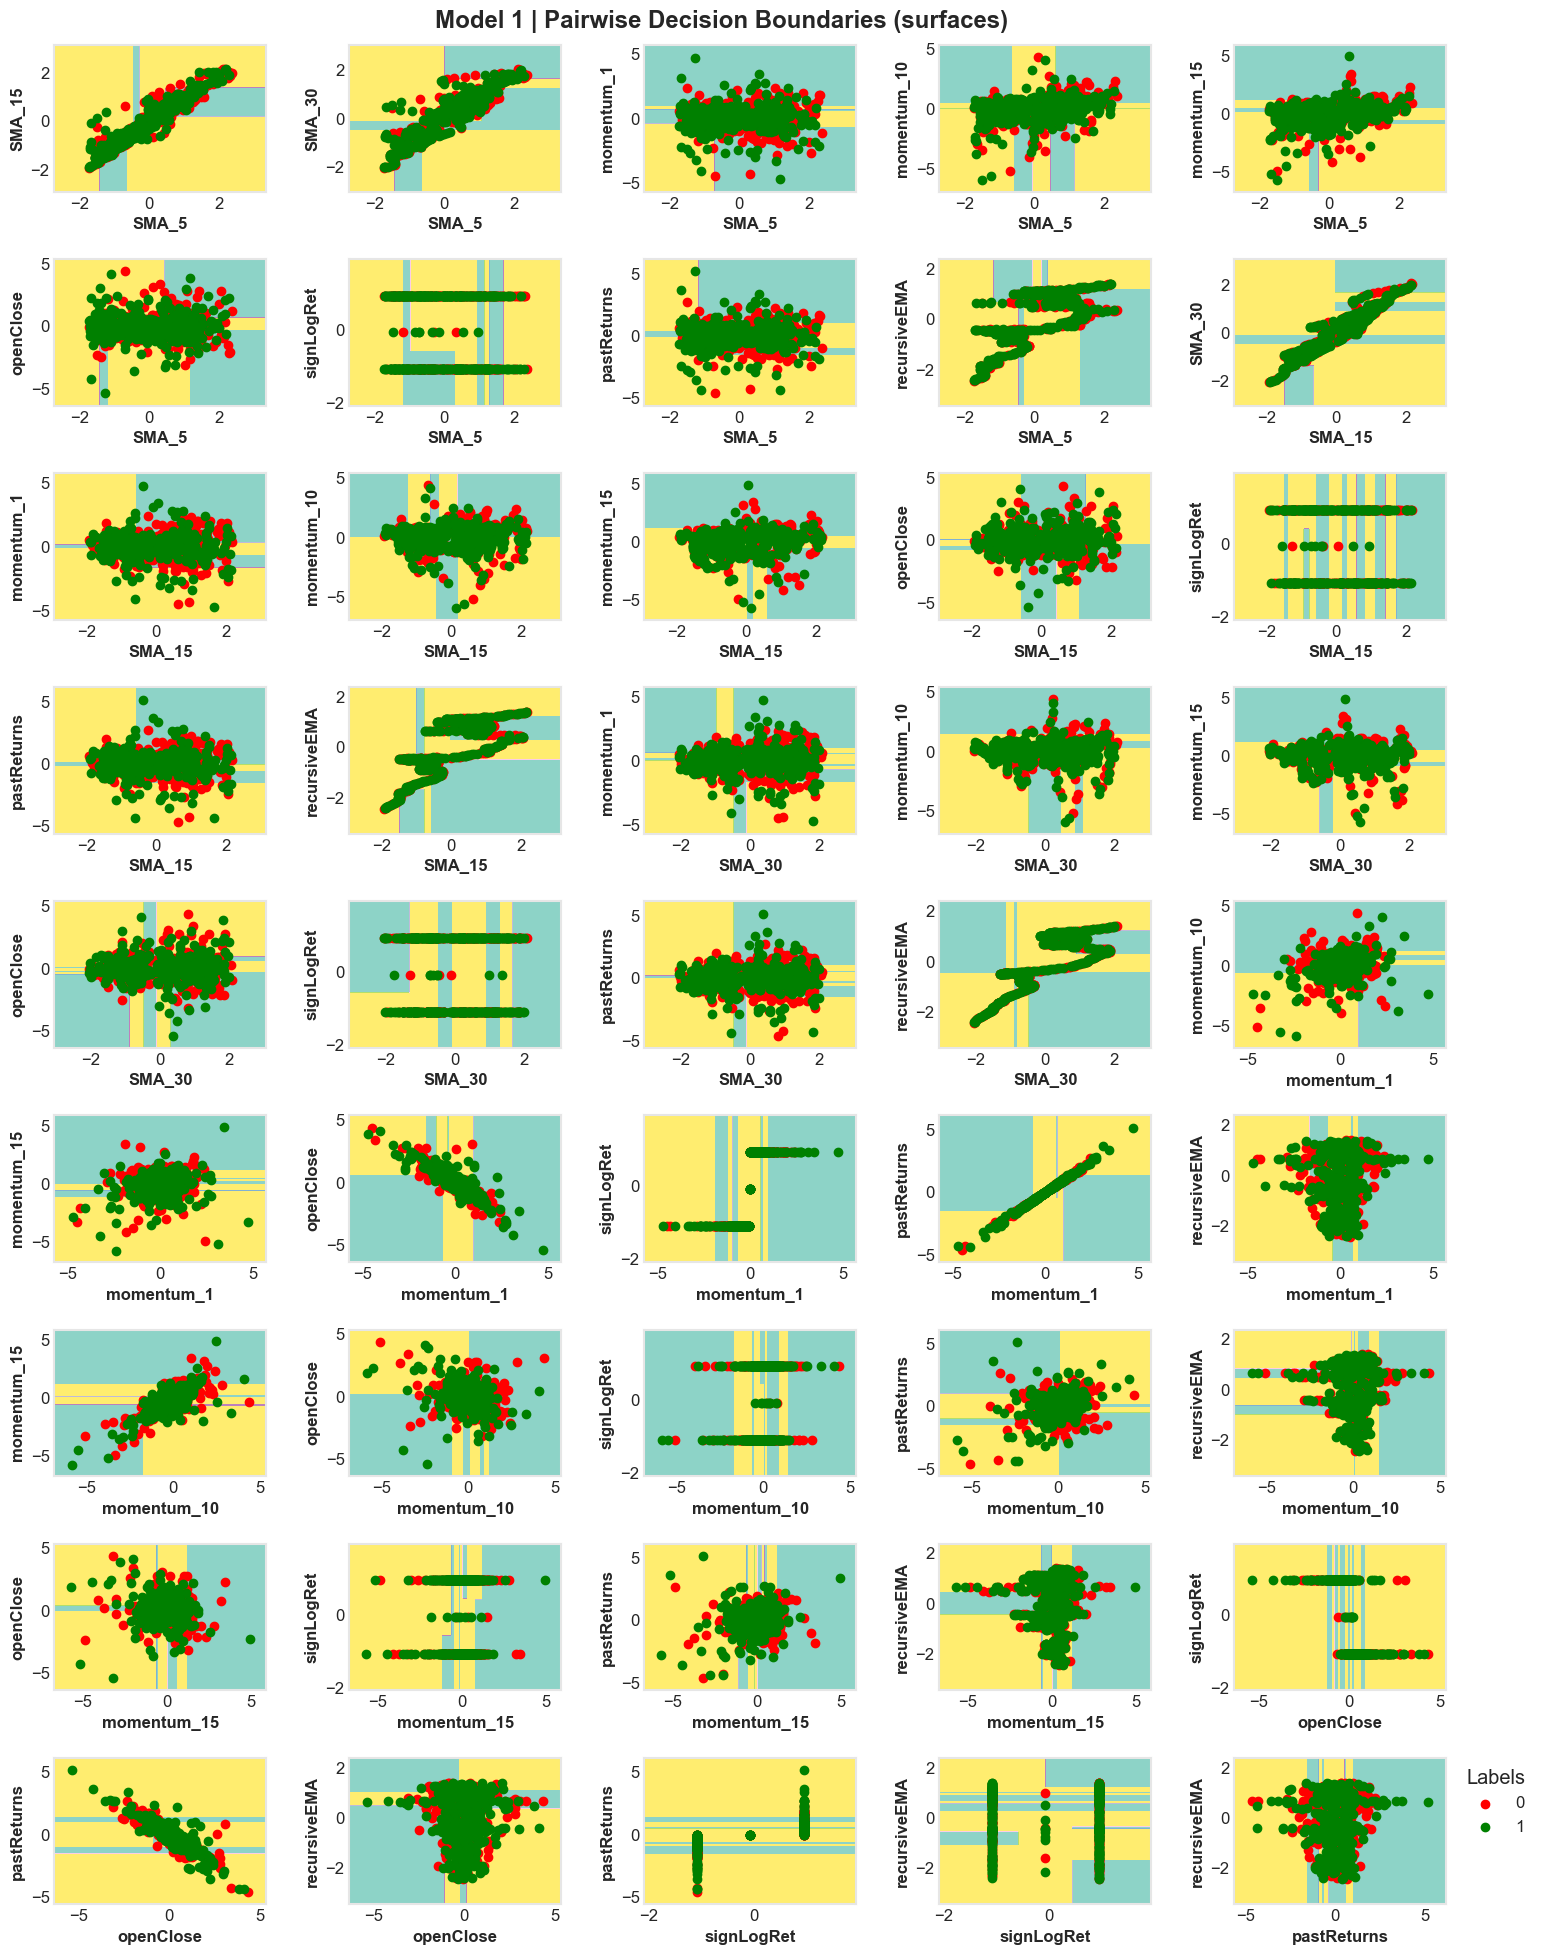

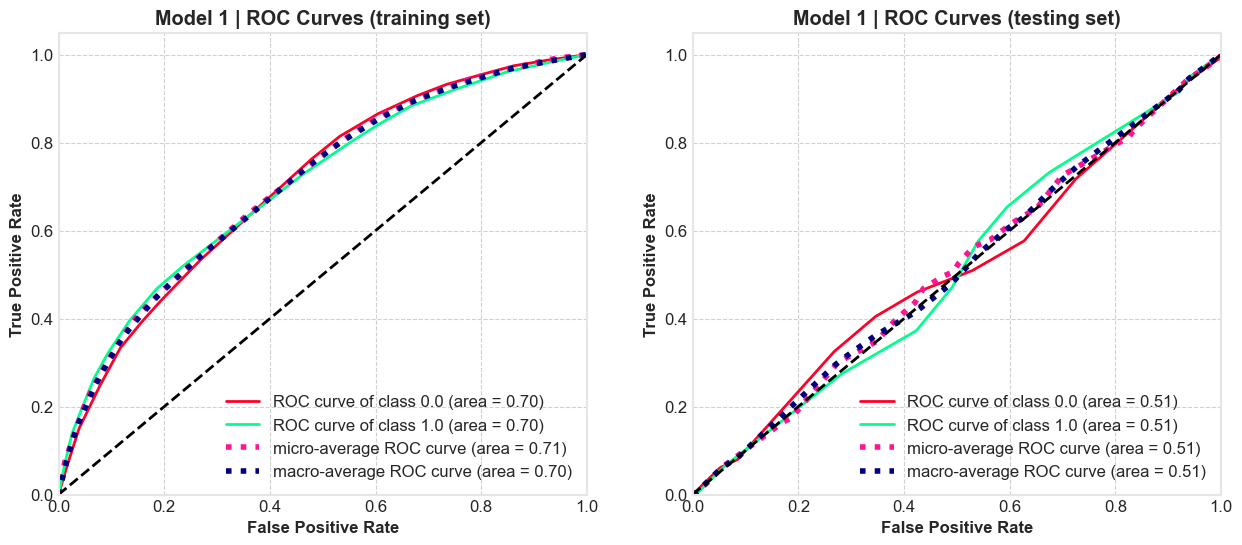

In [34]:
# plot decision boundaries for Model 1
plot_pairwise_surfaces(
    model=DecisionTreeClassifier(
        max_depth=bestModel1.max_depth, 
        min_samples_leaf=bestModel1.min_samples_leaf, 
        min_samples_split=bestModel1.min_samples_split),  
    X_data= X_train_f.sort_index(), 
    y_data= y_train_f.sort_index().Label, 
    list_features= list(X_train_f.columns),
    model_name="Model 1",
    vsubplots=9, hsubplots = 5,
    general_figsize=[15, 20],
    left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# plot ROC Curve for Model 1 over training and testing set
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
skplt.metrics.plot_roc(
    y_train_f.Label, bestModel1.predict_proba(X_train_f), 
    cmap=plt.cm.gist_rainbow, ax=ax1, 
)
ax1.set_title("Model 1 | ROC Curves (training set)", weight='bold')
skplt.metrics.plot_roc(
    y_test.Label, bestModel1.predict_proba(X_test), 
    cmap=plt.cm.gist_rainbow, ax=ax2, 
)
ax2.set_title("Model 1 | ROC Curves (testing set)", weight='bold')
plt.show()

Now, for **Model 2.1.**, we have:

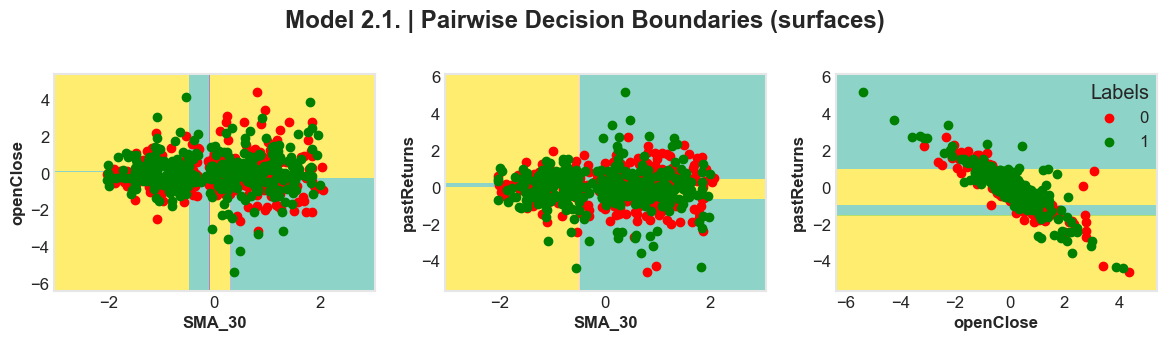

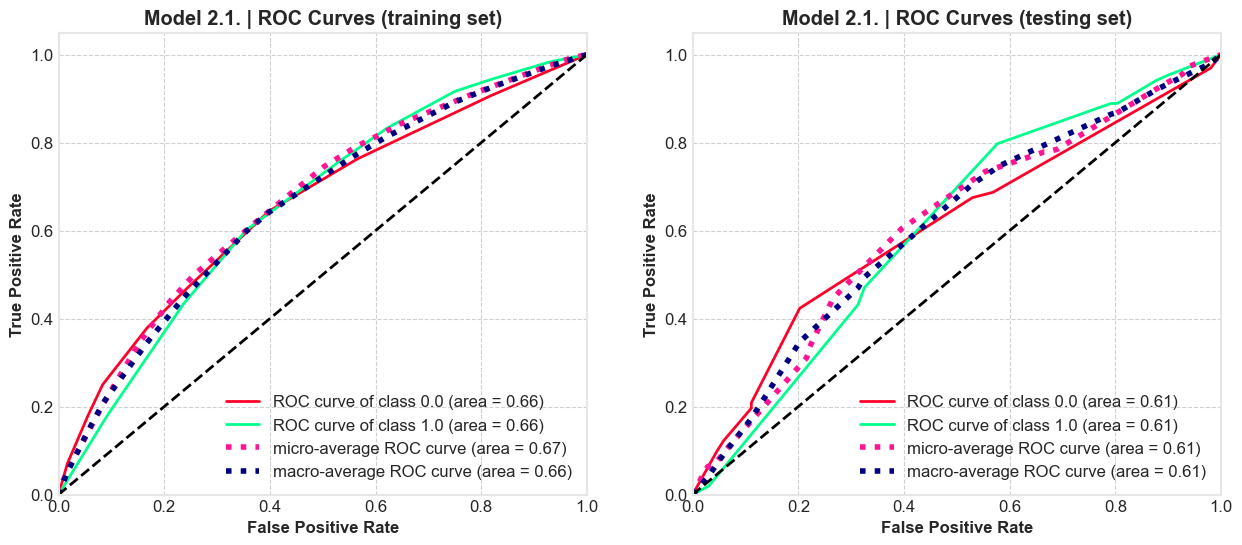

In [35]:
# definition of Model 2.1.
bestModel21 = specialCase[3]

# plot decision boundaries for Model 2.1.
plot_pairwise_surfaces(
    model=DecisionTreeClassifier(
        max_depth=bestModel21.max_depth, 
        min_samples_leaf=bestModel21.min_samples_leaf, 
        min_samples_split=bestModel21.min_samples_split, 
        min_impurity_decrease = bestModel21.min_impurity_decrease
    ),
    X_data= new_X_train_f,
    y_data= y_train_f.Label, 
    list_features= relevantFeatures,
    model_name="Model 2.1.",
    vsubplots=2, hsubplots = 3,
    general_figsize=[12, 6],
    left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# plot ROC Curve for Model 2.1. over training and testing set
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
skplt.metrics.plot_roc(
    y_train_f.Label, bestModel21.predict_proba(new_X_train_f), 
    cmap=plt.cm.gist_rainbow, ax=ax1, 
)
ax1.set_title("Model 2.1. | ROC Curves (training set)", weight='bold')
skplt.metrics.plot_roc(
    y_test.Label, bestModel21.predict_proba(new_X_test), 
    cmap=plt.cm.gist_rainbow, ax=ax2, 
)
ax2.set_title("Model 2.1. | ROC Curves (testing set)", weight='bold')
plt.show()

There are several considerations we should explain before draw a more general conclusion:

- The reader might notice we did not use an scaled version of our features dataset for the training/testing process of both models in this **Question 2**. This is because, generally speaking, this procedure is not an absolute requirenment, even more since tree-based algorithms are inmune to feature magnitude due to the fact they are information based algorithms—we used it for convenience in the step above just to get more scaled sufrace plots. Also, we want to avoid it because decision trees algorithm are sensitive to training set rotation, which means that a non well-defined transformation could lead us to a more unnecesary convoluted decision boundaries. 


- We decided to use a _pairwise features combination_ method to plot our decision boundaries, because it allow us a simple comparisson between the surfaces of both models. This is important, because **Model 1** works over a dataset that could be considered as "high-dimensional" ($10$ features). There are other alternative procedures to deal with this scenario, such as dimensionality reduction (e.g., PCA or T-SNE), to make a 2D decision boundary linearly separable. However, there are several drawbacks to consider: 1) comparisson with **Model 2.1.** would no longer be sensible, since they would be working on totally different surfaces; 2) apply a dimensionality reduction for **Model 2.1.** does not make any sense, since it works only over $3$ features; 3) we want to preserve interpretability (this was useful at the _feature importance_ stage), since we are working with Decision Trees (perhaps the most interpretable ML algorithm); and 4) Decision trees are non-linear models, so they are suitable precisely in the context of non-linearly separable data that we are facing here. However, PCA and other similar techniques are highly recommended when it is impossible to plot all the features combination—since we have 45 pairwise for **Model 1**, it is still at least feasible to plot without further complications.

Thus, from the plots done above and based on the results for both models of this **Question 2**, we can draw two specific issues for prediction quality:

**1) Generally speaking, the convoluted decision boundaries show us the prediction quality is affected by a _low signal-to-noise ratio_, being the _feature importance_ procedure the only method we have used to deal with it**.

This could be considered as the general issue. From the CQF lectures, we know that a decision boundary plot help us to get a better understanding of how the model works by looking its underlying complexity. So, in general, linearly separable data scenarios tend to be easier to face by ML algorithms than more convoluted ones. By looking how complex the surfaces are, we can get a hint of how confident the model could be in the aim of predicting new observations. In that sense, the surfaces of both models show us there are too many observations very near to the edge of the decision boundary. Therefore, we cannot expect a really nice prediction from them. This is because each class observation shares too much non-relevant information, in such a way it is difficult to access to a clear/simple (more linear) differentiation among them. In some way, this is a "natural" condition of financial markets, since they are governed by arbitrage and non-stationarity, leading to the _low signal-to-noise_ context. Nevertheless, **there is a considerable advantage of Model 2.1**—the first two decision boundaries (`[openClose, SMA_30]` and `[pastReturns, SMA_30]`) seems to be, more or less, distinguishable into two distinct regions. In this context, this is good, because this clarify us that our _feature importance_ analysis was sensible. However, they still facing the problems described previously. Moreover, we can even go further and propose that, since we used only $3$ features for **Model 2.1.** and due to the _low signal-to-noise ratio_, this procedure help us to give up some marginal signal, but a lot of noise as well; i.e., it works as a _denoising_ technique. Nevertheless, this _Feature Importance_ procedure its a relevant second-order tool in the aim of dealing with noise. There are several more rigorous _denoising_ techniques we can use to enhance the signal and reduce the noise, such as the _Marcenko-Pastur Theorem_, the _Constant Residual Eigenvalue method_ (for both see Lopez de Prado, 2020), and so on. Consequently, a better scope of the "signal-noise issue" could lead us to better decision boundaries and, hence, more powerful models.

**2) As a consequence of the previous issue, models suffers from a low capacity to distinguish between labels and, hence, they are close to randomness, which make them no reliable at all**. 

In some way, we have already explained this issue sections above, particularly for **Model 1**—since the ROC-AUC shows that, more or less, this model is close to `roc_auc=0.50`, we cannot trust on its predictions. It is correct that **Model 2.1.** achieved significant improvements on its prediction quality after the _Feature Importance_ step and a better definition of its attributions to split. However, from the confussion matrix and the metrics computed sections above, we can say this upgrade it is improvable: we get a better OOS accuracy and ROC-AUC, but in an imbalanced way, being more reliable on label 1 than the other one; also, second model achieved a better general performance, but it could be improved by a more well-structured _feature importance_ analysis, since we might be leaving aside other variables. Nevertheless, we would like to emphazise this is _not_ a problem of the model itself (either **Model 1** or **Model 2.1.**), because all ML models will find patterns even if they are not significant. In contrast, we strongly believe it is a consequence of how we get the data, the computed features, and the labeling method used. There is a huge probability that, given other type of bars (such as, for instance, "Information Driven Bars"), other informative features (e.g., microstructural/cross-sectional features), and other labeling methods (such as the "Trend scanning" method), we might get different (and maybe better) results for the same type of model. 

### 2.3. Question 3: Ensemble learning

#### 2.3.1. Technical experiment

Here, we are going to build our experiment that will hep us to decide whether to use an Adaboost or XGBoost as our **Model 3**. Since we already explain many equivalent processes in **Question 2**, and being this new model a tree-based algorithm as well, we will straightforward define the hyperparameters, each model, and get its results. Only at the end of the experiment we are going to explain and evaluate the reasons and outcomes of the implementations.  

So, let's first build our experiment in a the class `EnsembleEvaluation` to simplify its computation.

In [36]:
# General Evaluation Experiment
class EnsembleEvaluation(object):
    
    # general initialization method
    def __init__(self, 
                 label_name = "Label", 
                 n_splits=5, 
                 n_iter=100, 
                 random_state=None, 
                 gridmetric = "roc_auc", 
                 OOS_performance_evaluation = True, 
                 scoreMetrics = ["roc_auc", "accuracy", "f1_average"], 
                 print_info = True, 
                 digitMetrics =3):
        
        self.label_name = label_name
        self.n_splits = n_splits
        self.n_iter = n_iter
        self.random_state = random_state
        self.gridmetric = gridmetric
        self.OOS_performance_evaluation = OOS_performance_evaluation
        self.scoreMetrics = scoreMetrics
        self.print_info = print_info 
        self.digitMetrics = digitMetrics 

    # method 1: data scaling 
    def __scaling__(self, x_train, y_train, x_test, y_test, scaler, ret_scalend_train=False):

        assert type(y_train) == pd.DataFrame, \
        ">>> y_train/y_test should be pandas dataframe objects. Please, redefine." 

        # 1) fitting scaler using reduced training dataset
        scaler.fit(x_train)    
        # 2) defining our new training features dataset
        self.new_x_train = scaler.fit_transform(x_train)     
        # 3) defining our new training labels dataset
        self.new_y_train = y_train[self.label_name].values
        # 4) defining our new testing features dataset
        self.new_x_test = scaler.transform(x_test)
        # 5) defining our new testing labels dataset
        self.new_y_test = y_test[self.label_name].values
        if ret_scalend_train: return scaler.transform(x_test)
        
    # method 2: compute OOS metrics given prediction and list of metrics
    def __OOSMetricsComputation__(self, y_pred):
        assert len(self.scoreMetrics) > 1,\
        ">>> Should define a list of metrics list. Please, redefine."
        # empty dictionary to save OOS metrics
        dictMetrics = {}
        # iteration por metric to compute its OOS value
        for metric in self.scoreMetrics:
            if metric.lower() == "roc_auc":
                mVal = round(roc_auc_score(self.new_y_test, y_pred), self.digitMetrics)
            elif metric.lower() == "accuracy":
                mval = round(accuracy_score(self.new_y_test, y_pred), self.digitMetrics)
            elif metric.lower() == "f1_average":
                mVal = round(f1_score(self.new_y_test, y_pred, average='macro'), self.digitMetrics)
            else:
                sys.exit("Error!! Only 'roc_auc', 'accuracy' and 'f1_average' are allowed as metrics.")

            dictMetrics["OOS_"+metric.lower()] = mVal
        self.dictOOSMetrics = dictMetrics
    
    # method 3: Random Hypertunning
    def __randomizedTunningEVA__(self, ensemble, random_search_params):

        assert self.gridmetric.lower() == "roc_auc", \
        ">>> Only 'roc_auc' grid score is allowed. Please, redefined it" 

        # 1) randomized search cv of the ensemble model
        ensembleRGrid = RandomizedSearchCV(
            estimator = ensemble, 
            param_distributions = random_search_params, 
            cv = TimeSeriesSplit(n_splits=self.n_splits),
            verbose=2,  
            n_jobs = -1, 
            scoring=self.gridmetric,
            n_iter = self.n_iter,
            random_state = self.random_state
        )

        # 2) fitting randomized search with training data
        ensembleRGrid.fit(self.new_x_train , self.new_y_train )

        # 3) saving best estimator and best IS score
        self.best_estimator, self.best_is_score = \
        ensembleRGrid.best_estimator_, ensembleRGrid.best_score_

        # 4) checking if printing information is available:
        if self.print_info: 
            print(f":::>>> Ensemble Best Estimator: {self.best_estimator}")
            print(f":::>>> Ensemble Best I-S score: {self.best_is_score}")

        # 4) compute emsemble OOS predictions
        self.y_pred = self.best_estimator.predict(self.new_x_test)        

        # 6) get OOS score of best estimator
        if self.OOS_performance_evaluation:
            self.__OOSMetricsComputation__(y_pred = self.y_pred)
    
    # main method: get experiment
    def get_evaluation(self, 
                       estimator, 
                       random_params, 
                       x_train, y_train, x_test, y_test, 
                       scaler):
        
        # scaling data process
        self.__scaling__(x_train, y_train, x_test, y_test, scaler)
        
        # Random Grid Search
        self.__randomizedTunningEVA__(
            ensemble=estimator, 
            random_search_params=random_params
        )
        
        # retuning general results
        dictISInformation = \
        {"best_estimator": self.best_estimator, "best_is_" + self.gridmetric: self.best_is_score}
        __dictResults = {**dictISInformation, **self.dictOOSMetrics}
        return {"model"+type(estimator).__name__ : __dictResults}

Now, we can define our ensemble models, its configuration and its hyperparameter to test.

In [37]:
# 1.1) Model 3.1. | Adaboost classifier 
adaModel = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(random_state=0),
    algorithm= "SAMME.R", # this is to take an advatange of the 'predict_proba' method
    learning_rate = 0.001,
)
# 2.1) hypertunning params for our Adaboost 
ada_params_dict = {
    "base_estimator__max_depth": [bestModel21.max_depth],
    "base_estimator__min_samples_leaf": [bestModel21.min_samples_leaf],
    "base_estimator__min_samples_split": [bestModel21.min_samples_split],
    "base_estimator__min_impurity_decrease":[bestModel21.min_impurity_decrease],
    "n_estimators": range(10, 500, 10), 
}

# 1.2) Model 3.2. | XGBoost Classifier
xgb = XGBClassifier(
    verbosity = 0, 
    silent=True, 
    random_state = 0, 
    eval_metric="auc"
)

# 2.2) hypertunning params for our XGBoost
xgBoost_params_dict = {
        'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.3, 0.35, 0.5], 
        'min_child_weight': [1, 1.25, 1.5, 1.75, 2],
        'gamma': [0.5, 1, 3, 5, 7, 10], 
        'subsample': [0.5, 0.6, 0.8, 0.9, 1, 1.25, 1.5], 
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0], 
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
        }

So, first we can apply the experiment to get our **Adaboost Classifier**:

In [38]:
# Model 3.1. : Adaboost Classifier 
adaBoostInformation = \
EnsembleEvaluation(n_iter=int(1e2), random_state = 0, print_info=False).get_evaluation(
    estimator =  adaModel, random_params = ada_params_dict, 
    x_train = new_X_train_f, y_train = y_train_f, x_test = new_X_test, y_test = y_test, 
    scaler = StandardScaler()
)
print(">>> Model 3.1. | Adaboost Classifier:")
print(f"::>>> General Information: \n{adaBoostInformation}")

Fitting 5 folds for each of 49 candidates, totalling 245 fits
>>> Model 3.1. | Adaboost Classifier:
::>>> General Information: 
{'modelAdaBoostClassifier': {'best_estimator': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         min_impurity_decrease=0.0025,
                                                         min_samples_leaf=26,
                                                         min_samples_split=70,
                                                         random_state=0),
                   learning_rate=0.001, n_estimators=400), 'best_is_roc_auc': 0.5591370903850614, 'OOS_roc_auc': 0.541, 'OOS_accuracy': 0.541, 'OOS_f1_average': 0.541}}


Now, we can do the same to get our **XGBoost Classfier**:

In [39]:
# Model 3.2. : XGBoost Classifier 
XGBoostInformation = \
EnsembleEvaluation(n_iter=int(1e2), random_state = 0, print_info=False).get_evaluation(
    estimator =  xgb, random_params = xgBoost_params_dict, 
    x_train = new_X_train_f, y_train = y_train_f, x_test = new_X_test, y_test = y_test, 
    scaler = StandardScaler()
)
print(">>> Model 3.2. | XGBoost Classifier:")
print(f"::>>> General Information: \n{XGBoostInformation}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
>>> Model 3.2. | XGBoost Classifier:
::>>> General Information: 
{'modelXGBClassifier': {'best_estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='auc', gamma=5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=9,
              min_child_weight=1.5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0), 'best_is_roc_auc': 0.5629640256712208, 'OOS_roc_auc': 0.602, 'OOS_accuracy': 0.602, 'OOS_f1_average': 0.594}}


Finally, we are able to explain briefly our empirical study, as well as giving some insights about the results obtained above.

#### 2.3.2. The study design

Our experiment starts by tunning the hyperparameters for both models. However, we have used different approaches for each of them. On one hand, we have regularized the values of the hyperparameters for our `AdaBoostClassifier`. This means that we have decided to use the structure of our best previous tree (**Model 2.1.**) as the base estimator for this new ensemble model. Similarly, we defined an specific value for its `learning_rate` ($0.001$). This means that we are controlling how much the new "weak estimator" will contribute over the existing ones. This regularization value will basically allow us to _prune_ our general ensemble, since it precisely prevents the meta-model from overfitting. Therefore, it works as our main pruning parameter. Also, since there is a trade-off between this and the number of estimators (`n_estimators`), the latter has been tested into the tuning process (in fact, it is the only one there). It is important to mention that, based on some experiments done in this sort of models, a `learning_rate < 0.1` tends to be a sensible choice (see Friedman, 2001). Notice that we could also start by the opposite process, defining first a maximum number of estimators, and try different values to find the optimal learning rate—the result should be the same. However, defining a learning ratio is usually more appropriate since the number of estimators works on positive integers; thus, a smaller universe can be used to test on them. Finally, it is necessary to point out that this "regularization/prunning" approach adopted for this model is due to the fact that the `AdaBoostClassifier` is usually very sensitive to outliers, not being able to generalize correctly in a naive context. Consequently, either by implementing a fixed structure to our base estimator, or by defining an specific value for certain hyperparameters, we seek to reduce that risk by using this approach.

On the other hand, we decided to use our `XGBoostClassifier` as free as possible. Essentially, because there is a lot of dependency between its hyperparameters (for example, between `learning_rate` and `max_depth`, or `subsample` and `colsample_bytree`, and so on). Therefore, trying to find a "formulae" as in the AdaBoostClassifier is a little bit more difficult here. In that sense, we have not worked deeply on the aspect of regularization or pruning for this new ensemble model. However, since XGBoost has many hyperparameters, it is necessary to choose which one to use. The first as we said is the `learning_rate`. The criteria for this hyperparameter is the same as for `AdaBoostClassifier`—the only difference, of course, is that here we have used the reference of $0.001$ as our initial value, extending it to $0.5$ (notice that, even here, the model chose $0.001$ as the optimal value, the same as in the `AdaBoostClassifier`). We applied the same criteria as well for the maximum depth of the estimator: we provide a sensible range of values that can work paralelly well with the defined learning rate alternatives. The latter is, in the case of XGBoost, the main hyperparameter to control overfitting, since a greater depth usually gets greater complexity in the model and, thus, low generalization capability. Also, this value consumes considerable computational memory, so it should not be tested freely. To do this, we reduce only to the interval between $3$ to $10$. In that sense, in the same way that we define a minimum impurity reduction to our best tree (**Model 2.1.**), we can define it here by using `gamma`, i.e., the minimum loss required to make a split. The goal is to use a gamma value neither too large nor too small, since the larger it is, the more conservative the model will be (and, also, the greater the risk of underfitting). Therefore, we define values ranging from $0.5$ to $10$, discretionally selected. We apply the same criteria for the minimum weight for each child-tree (`min_child_weight`) of the meta model and, thus, also needs to be tuned. Likewise, we seek to know which ratio of subsamples for each column can be useful for the ensemble, so we define the interval from $0.5$ to $1.0$ every $0.1$ for the hyperparameter `subsample`, the ratio of columns (features) necessary to build each tree. By defining this, we must do the same for the fraction of observations that will be randomly sampled by each new tree, i.e., for the hyperparameter `colsample_bytree`. Thus, with these 4 hyperparameters we are, more or less, confident enough that we are covering the majority of XGBoost important properties.

So, our experiment is based on finding the optimal hyperparameters for each model, and evaluating their OOS metrics. We used our reduced features dataset defined after our _Feature Importance_ process (see section 2.2.1.3.). Moreover, notice we have scaled this dataset as the first step of our experiment (method **scaling**). We did not do these for our first two tree-based models. This is because, at least for `XGBoostClassifier`, it is extremely necessary to have an scaled training dataset, not being so mandatory for the `AdaBoostClassifier`, but important as well to the aim of a better comparisson between them. Being saying that, **what we can say about our experiment results?** Essentially, there is significant difference between the OOS performance of both models: while the `AdaBoostClassifier` is very poor (an `OOS ROC-AUC=0.541`, better than **Model 1** but worst than **Model 2**), the `XGBoostClassifier` seems to be more reliable. In fact, the differences between the latter and our best previous **Model 2.1.** is so small (an `OOS_roc_auc` of $0.602$ v.s. $0.6103$ respectively), that we can even say we have two equivalent models of sensible quality. But, why an `XGBoost` could perform better than an `AdaBoost` here? We did not consider this is due to the fact that an `XGBoost` tends to be a stronger algorithm by itself. In contrast, we believe that its better performance is more related to the context in which both algorithms are working: a **low signal-to-noise ratio** environment. Since the `AdaBoost` is more sensitive to outliers, noise, and other related factors, it is natural that, even by using our best previous best model as it base estimator, its performance did not seems very well. 

In the next section, we are going to use **Model 2.1.** to compute our **P&L Backtesting** (being our previous **XGBoostClassifier** our second best model).

### 2.5. Question 4: P&L Backtesting

Since our best estimator was **Model 2.1.**, we are going to use it as our ML predictor to compute our backtesting. Thus, following the _kelly criterion_, our _bet size rule_ will be defined as:

$$
\text{betsize} = 2p_j - 1
$$

Being $p_j:=\text{probability of our label of interest}\space j$. 

Based on **Model 2.1.** performance, we decided to trade **long only**. In that sense, wer are interested on $p_1$ for each event, being label $0$ and, thus, $p_0$ non relevant for us. Hence, if $p_1 < 0.5$, we will set it as $0.5$ to be deleted as an investing alternative by the _bet size rule_ ($2\times(0.5)-1=0$, i.e., no investing). Moreover, the compound gains will be calculated considering the remaning cash with an earning rate of $0\%$. This _kelly criterion_ will be our base trading strategy, while a simple 100% allocation approach will be useful as benchmark. Also, to avoid any _look ahead bias_, we will work only over the `testing dataset` to compute our backtesting—this goes from **27th January, 2020 to 27th April, 2021**. 

Finally, because of the requirenment asks to use a non-optimal `min_samples_leaf`, we decide to preserve our estimated value of $26$ for this hyperparameter since it was not part of the hypertunning stage.

Therefore, directly computing the performance, we can get:

In [40]:
# ML predictor
print(f">>> Trading predictor: {bestModel21}")

>>> Trading predictor: DecisionTreeClassifier(max_depth=5, min_impurity_decrease=0.0025,
                       min_samples_leaf=26, min_samples_split=70)


In [41]:
# defining our backtesting time-framework from our testing label dataset
backtesting_events = y_test.rename_axis(None).copy()
print(">>> General Trading Information:")
print(f":::>>> Total backtesting possible trades: {backtesting_events.shape[0]}")
print(f":::>>> Total hits (label 1) to achieve: {backtesting_events.query('Label==1').shape[0]}")

>>> General Trading Information:
:::>>> Total backtesting possible trades: 316
:::>>> Total hits (label 1) to achieve: 153


In [42]:
# computing label 1 proba from trading predictor and change it when p1<0.5
__predictorProba = bestModel21.predict_proba(new_X_test)[:,1]
__predictorProba[__predictorProba<0.5] = 0.5

# saving new predictors proba as our 'p1' value
backtesting_events["p1"] = __predictorProba

# computing betsize rule
backtesting_events["betsize"] = (2 * backtesting_events["p1"]) -1

# computing the strategy based on the kelly criterion (base trading strategy)
backtesting_events["strategy_kelly"] = backtesting_events["fwd_returns"] * backtesting_events["betsize"]

# computing the 100% allocation strategy (benchmark trading strategy)
backtesting_events["strategy_100"] = \
backtesting_events["fwd_returns"] * backtesting_events["p1"].apply(lambda p1: 0 if p1==0.5 else p1)

# taking a look about the backtesting dataset
backtesting_events.head()

,fwd_returns,Label,p1,betsize,strategy_kelly,strategy_100
2020-01-27,-0.002136,0.0,0.500000,0.000000,-0.000000,-0.000000
2020-01-28,0.004756,1.0,0.669118,0.338235,0.001609,0.003182
2020-01-29,-0.008284,0.0,0.669118,0.338235,-0.002802,-0.005543
2020-01-30,-0.018616,0.0,0.669118,0.338235,-0.006297,-0.012456
2020-01-31,0.018239,1.0,0.500000,0.000000,0.000000,0.000000


Finally, using this data, we can compute our backtesting plots:

>>> P&L BACKTESTING RESULTS:
**************************************************
:::>>> Performance metrics | Strategy: 'Kelly Optimal Bets'


Start date,2020-01-27
End date,2021-04-27
Total months,15
,Backtest
Annual return,8.0%
Cumulative returns,10.1%
Annual volatility,5.8%
Sharpe ratio,1.35
Calmar ratio,1.30
Stability,0.90
Max drawdown,-6.2%


------------------------------------------------------------
:::>>> Performance metrics | Strategy: '100% Bets'


Start date,2020-01-27
End date,2021-04-27
Total months,15
,Backtest
Annual return,25.6%
Cumulative returns,33.1%
Annual volatility,13.4%
Sharpe ratio,1.77
Calmar ratio,2.11
Stability,0.93
Max drawdown,-12.2%


**************************************************
>>> P&L BACKTESTING PlOTS:


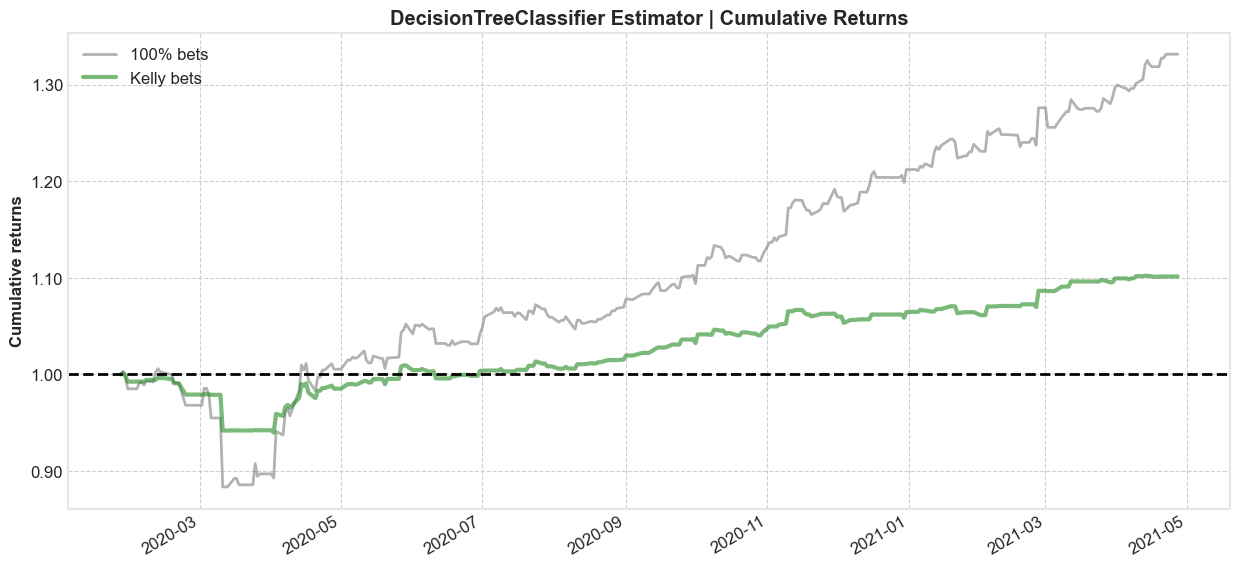

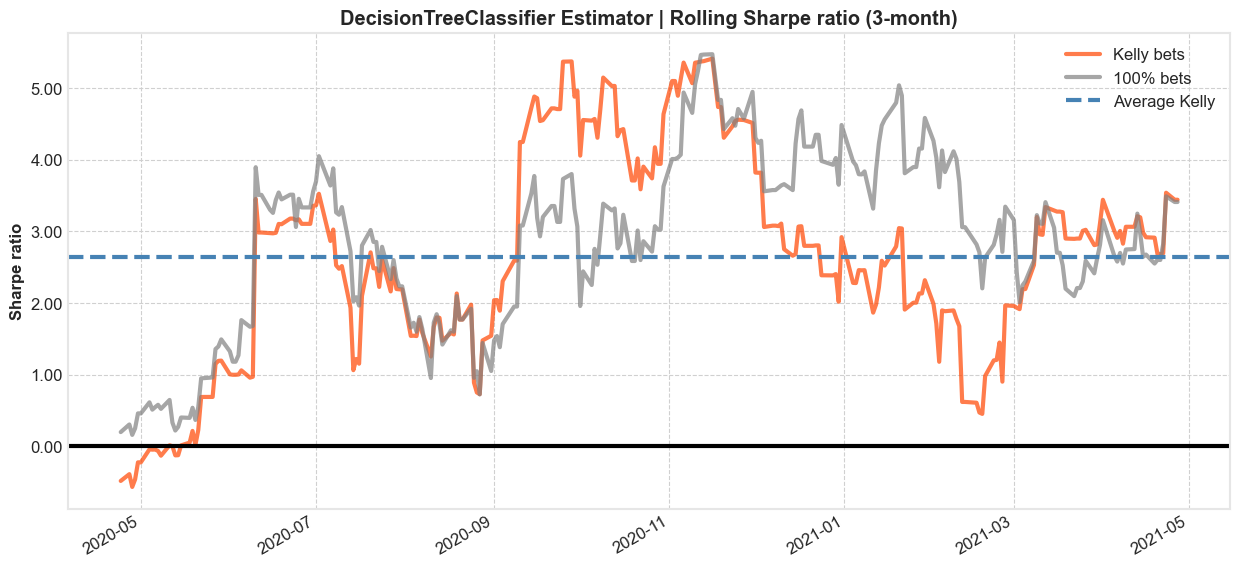

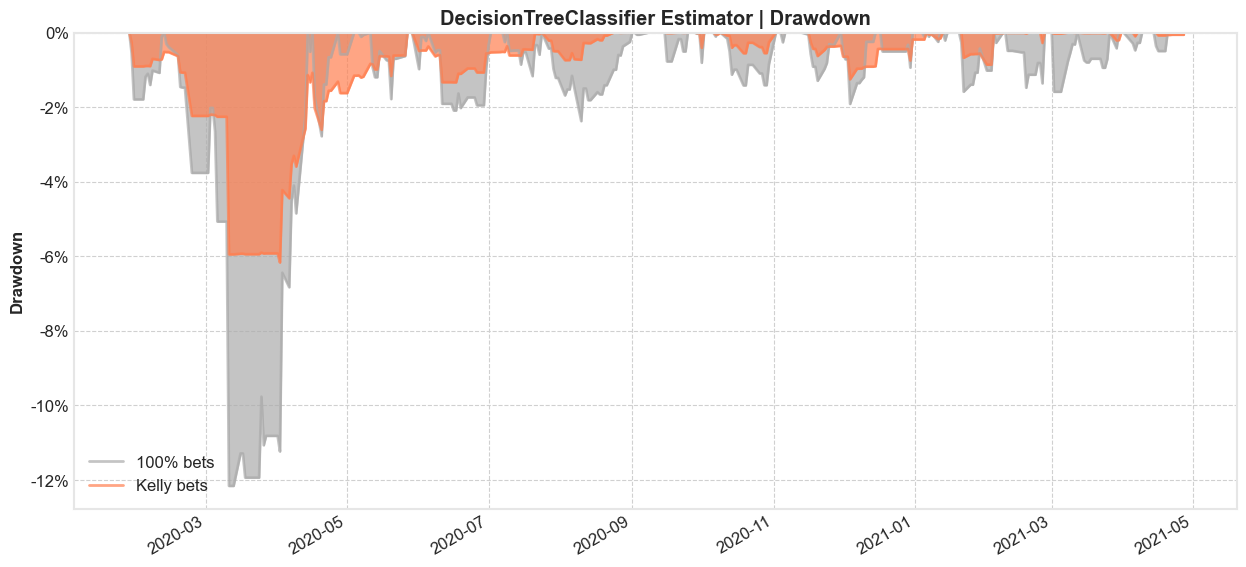

In [43]:
# generate backtesting performance metrics
print(colored('>>> P&L BACKTESTING RESULTS:', 'blue', attrs=['bold']))
print("*****"*10)

# getting performance metrics for Kelly optimal bets strategy
print(colored(":::>>> Performance metrics | Strategy: 'Kelly Optimal Bets'", attrs=['bold']))
pf.show_perf_stats(backtesting_events["strategy_kelly"])
print("------"*10)

# getting performance metrics for 100% bets strategy
print(colored(":::>>> Performance metrics | Strategy: '100% Bets'", attrs=['bold']))
pf.show_perf_stats(backtesting_events["strategy_100"])
print("*****"*10)

# generate backtesting plots
print(colored('>>> P&L BACKTESTING PlOTS:', 'blue', attrs=['bold']))

# plotting cumulative returns
pf.plotting.plot_rolling_returns(
    backtesting_events["strategy_kelly"], 
    backtesting_events["strategy_100"],
    figsize=(15,7))
plt.title(f"{type(bestModel21).__name__} Estimator | Cumulative Returns", weight='bold')
plt.legend(["100% bets", "Kelly bets"])
plt.show()

# plotting rolling sharpe ratio (63 days or 3-month basis)
pf.plot_rolling_sharpe(
    backtesting_events["strategy_kelly"], 
    backtesting_events["strategy_100"], 
    rolling_window=63, figsize=(15,7)
)
plt.title(f"{type(bestModel21).__name__} Estimator | Rolling Sharpe ratio (3-month)", weight='bold')
plt.legend(["Kelly bets", "100% bets", "Average Kelly"])
plt.show()

# plotting drawdown/underwater plot
ax100bet=pf.plot_drawdown_underwater(backtesting_events["strategy_100"], figsize=(15,7))
ax100bet.findobj()[0].set_color("#ACACAC")
ax100bet.findobj()[1].set_color("#ACACAC")
pf.plot_drawdown_underwater(backtesting_events["strategy_kelly"], figsize=(15,7))
plt.title(f"{type(bestModel21).__name__} Estimator | Drawdown", weight='bold')
plt.legend(["100% bets", "Kelly bets"])
plt.show()

## References

**[1]** López de Prado, M. (2018). _Advances in Financial Machine Learning_ (1st ed). Cap. 2, 3, 7, & 8. Willey.

**[2]** López de Prado, M. (2020). _Advances in Financial Machine Learning_ (1st ed). Cap. 2.3, 2.6, 5.4 & 6. Cambridge U. Press.

**[3]** Friedman, Jerome H. "Greedy Function Approximation: A Gradient Boosting Machine." _The Annals of Statistics_, vol. 29, no. 5 (2001), pp. 1189–232. JSTOR, http://www.jstor.org/stable/2699986. Accessed 01 Jun. 2022.

___

<center>CQF Module 4 Assigment 3 finished